
# Technical appendix - DEMANDMODELLING

## A. Objectives & scope

* **Goal:** robust demand modelling pipeline spanning data preparation, clustering-based segmentation, and SARIMA-based forecasting with reproducible outputs (`clustering_results.csv`, `forecasting.csv`, persona summaries).
* **Primary entities:** `entity` (e.g., meter/region), `period`/`aggregation_period`, `quantity` (target), `unit`, optional flags like `has_PV`, and engineered features (`month_sin/cos`, `quarter_sin/cos`, `weekday_weekend`, embeddings `emb_x/emb_y`).
* **Deliverables:** trained artefacts under `models/`, plots under `reports/figures/`, and shareable tables under `reports/tables/`.

## B. Data contracts & validation

* **Sources:** CSV/Parquet from `data/raw/` → validated into `data/interim/` via `schemas.py` (Pandera).
* **Minimum required columns:**

  * `entity: str`, `period: datetime64[ns]`, `quantity: float`, `unit: str`
* **Recommended optional columns:** `aggregation_period: str`, `has_PV: bool`, `primary_space_heating_fuel: str`.
* **Constraints (examples):**

  * `quantity ≥ 0` for consumption-like targets; allow limited negative values only when modelling net export.
  * `period` strictly increasing per `entity`; duplicates disallowed post-aggregation.
  * Missingness thresholds enforced by `PrepConfig.drop_high_missing` (configurable).
* **Schema evolution:** any column addition/removal must increment package minor version and add a migration note in `CHANGELOG.md`.

## C. Data preparation (PrepConfig, DataPrepPipeline)

* **Casting:** explicit dtype map from config; coercion errors logged with row counts.
* **Renames:** centralised rename map to canonical snake\_case names.
* **Profiling outputs:** `basic_profile()` returns shape, dtype map, NA counts; `inspect_categoricals()` prints top-k levels.
* **Missing data:** per-column NA% computed; columns above threshold dropped or imputed; time series gaps filled with forward-fill then seasonal median where applicable.
* **Feature engineering:**

  * **Calendar:** cyclical encodings for month and quarter; binary `weekday_weekend`.
  * **Scaling:** `StandardScaler` for features used in PCA/KMeans; targets left unscaled for SARIMA.
  * **Leakage guard:** features aligned using safe `shift(lag)` when using past window features.

## D. Segmentation (PCA + KMeans)

* **Embedding:** PCA on standardised feature matrix to produce `emb_x`, `emb_y` for interpretability.
* **Clustering:** KMeans with fixed `random_state`; elbow and silhouette diagnostics saved to `reports/figures/`.
* **Cluster labelling:** heuristics map metrics to human-readable `persona_label` and `Cluster Name`. Export `cluster_persona_summary.csv`.
* **Stability checks:** multiple initialisations; adjusted Rand index across seeds (optional).

## E. Forecasting (SARIMAX)

* **Model class:** `sarima.py` wraps `statsmodels` SARIMAX with optional exogenous regressors (e.g., calendar dummies, cluster assignments).
* **Seasonality:** support for `m ∈ {7, 12, 24, 48}` depending on aggregation; configurable via `sarima.yaml`.
* **Hyperparameter search:** grid over `(p,d,q)×(P,D,Q)` with Akaike/BIC ranking; coarse grid narrowed by residual diagnostics (Ljung–Box).
* **Backtesting:** rolling-origin with expanding window; metrics: `MAE`, `RMSE`, `MAPE`. Per-entity fold summaries aggregated and written to `reports/tables/forecasting.csv`.
* **Diagnostics:** residual autocorrelation plots, forecast vs. actual plots stored under `reports/figures/`.

## F. Evaluation & reporting

* **Regression metrics:** `metrics.py` computes per-entity and macro-averaged scores; confidence intervals via block bootstrap (optional).
* **Clustering metrics:** inertia, silhouette, Davies–Bouldin; cluster size distributions; correlation of `quantity` with cluster labels (optional `Positive_Correlation_Label`).
* **Personas report:** table with cluster centroids, top features, `peak_month`, `dominant_vector`.
* **Export policy:** every artefact includes a `metadata.json` with git commit hash, run timestamp, config fingerprint.

## G. Reproducibility & ops

* **Determinism:** `utils.seed_everywhere(seed)` seeds Python/NumPy/sklearn; SARIMAX randomness limited to initialisation.
* **Environment:** lock dependencies in `pyproject.toml`; compile to requirements.txt for Docker image.
* **Pre-commit:** black (line length 100), ruff (E/F/I), isort, nbstripout for notebooks.
* **CI:** run `make lint test`; cache pip and dataset checksum; on `main` tag, attach `reports/` and `models/` as artefacts.

## H. Testing strategy (pytest)

* **Unit tests:** pipeline steps (type casting, renames, NA handling), feature encoders, PCA variance ratios, KMeans labels shape, SARIMA forecasting API.
* **Property-based tests:** invariants like “scaler.inverse\_transform(transform(x)) ≈ x”.
* **Golden files:** small fixtures under `tests/fixtures/` for IO round-trips and stable plots hashes (loose tolerance).

## I. Command-line interface (Typer/argparse)

* **Prep:** `python -m demand_modelling.cli.prep --config configs/data_prep.yaml`
* **Cluster:** `python -m demand_modelling.cli.cluster --config configs/clustering.yaml --input data/processed/train.parquet --out reports/tables/clustering_results.csv`
* **Forecast:** `python -m demand_modelling.cli.forecast --config configs/sarima.yaml --input data/processed/train.parquet --horizon 12 --out reports/tables/forecasting.csv`
* **Report:** `python scripts/build_report.py --tables reports/tables/ --figs reports/figures/ --out reports/report.html`

## J. File formats & naming

* **Tables:** CSV/Parquet with UTF-8; snake\_case columns; datetime in ISO-8601.
* **Models:** joblib/pickle with versioned filenames (`sarima_entity=XYZ_v{semver}.pkl`).
* **Figures:** `.png` at 2× DPI; SVG for vector diagrams.

## K. Security & privacy

* **PII:** none expected; if present, hash IDs with salted SHA-256 post-ingest.
* **Secrets:** never committed; `.env` loaded via `python-dotenv` in CLI entrypoints.
* **Licensing:** third-party licence summary in `NOTICE.md`.

## L. Migration from notebook to package

* **Module extraction:** move `PrepConfig`, `DataPrepPipeline` → `src/demand_modelling/prep/`; `EnergyForecaster` → `src/demand_modelling/forecasting/sarima.py`; plotting theme → `plotting.py`.
* **Refactor cells:** convert notebook sections into functions/classes with docstrings and type hints; keep exploratory EDA in `notebooks/` with nbstripout enabled.
* **Optionally** adopt Jupytext pairing (`.ipynb` ⇄ `.py`) for literate workflow.


In [14]:

# =============================================================================
# Project structure
# =============================================================================

# demand-modelling/
# ├── pyproject.toml                 # Build + pinned deps (poetry/pip-tools). Python ≥3.10
# ├── README.md                      # Project overview and quickstart
# ├── .env.example                   # Template for secrets & runtime vars
# ├── .gitignore                     # Ignore data/artefacts/logs, *.ipynb_checkpoints
# ├── .pre-commit-config.yaml        # Black, Ruff, isort, nbstripout hooks
# ├── Makefile                       # Reproducible CLI: make setup|train|forecast|report|test
# ├── docker/                        # Container build context
# │   ├── Dockerfile                 # CPU image with system libs for statsmodels/sklearn
# │   └── start.sh                   # Entrypoint/healthcheck
# ├── configs/                       # All run-time configuration (YAML/TOML)
# │   ├── data_prep.yaml             # Mirrors PrepConfig fields (thresholds, rename map, etc.)
# │   ├── clustering.yaml            # n_clusters grid, scaling flags, random_state
# │   ├── sarima.yaml                # (p,d,q)(P,D,Q)m search space & exogenous config
# │   └── reporting.yaml             # Plot/theme toggles, figure DPI, table limits
# ├── data/                          # Data Lake-style layout (read-only except interim)
# │   ├── raw/                       # Immutable source extracts (CSV/Parquet) with checksums
# │   ├── interim/                   # Row/column filtered, but still reversible
# │   └── processed/                 # Feature-complete model-ready tables
# ├── notebooks/                     # Exploration and research notebooks
# │   └── DemandModelling.ipynb      # (uploaded) source EDA/feature/clustering/forecasting
# ├── src/                           # Installable package: demand_modelling
# │   └── demand_modelling/
# │       ├── __init__.py            # Version, public API
# │       ├── logging.py             # Structured logging config (JSON console, file handlers)
# │       ├── io.py                  # Reading/writing CSV/Parquet; schema enforcement
# │       ├── schemas.py             # Pandera/pyarrow schemas for tables
# │       ├── utils.py               # Common helpers (seed_everywhere, timer, caching)
# │       ├── plotting.py            # set_theme(), palettes, Matplotlib helpers
# │       ├── prep/                  # Data preparation pipeline
# │       │   ├── __init__.py        # Re-export PrepConfig, DataPrepPipeline
# │       │   ├── config.py          # @dataclass PrepConfig (rename map, NA thresholds, dtypes)
# │       │   └── pipeline.py        # DataPrepPipeline: load→profile→clean→encode→export
# │       ├── features/              # Feature engineering (time & categorical)
# │       │   ├── calendar.py        # month/quarter cyclical encodings, holidays, lags
# │       │   └── transforms.py      # Scaling, winsorization, target transforms
# │       ├── clustering/            # Segmentation (KMeans/PCA/metrics)
# │       │   ├── embed.py           # PCA embeddings emb_x/emb_y
# │       │   ├── kmeans.py          # fit/predict, inertia, silhouette, elbow diagnostics
# │       │   └── personas.py        # Cluster labeling & persona summaries
# │       ├── forecasting/           # Time series models
# │       │   ├── sarima.py          # SARIMAX wrapper, CV, diagnostics, exogenous handling
# │       │   ├── decomposition.py   # STL/seasonal_decompose utilities
# │       │   └── backtest.py        # Rolling-origin evaluation; MAE/MSE/MAPE metrics
# │       ├── evaluation/            # Model selection & reporting
# │       │   ├── metrics.py         # Regression + clustering metrics
# │       │   └── reporting.py       # Tables (cluster_persona_summary.csv, forecasting.csv)
# │       └── cli/                   # Thin CLIs for pipelines (argparse/typer)
# │           ├── prep.py            # run data prep from configs/data_prep.yaml
# │           ├── cluster.py         # run PCA+KMeans, export clustering_results.csv
# │           └── forecast.py        # train SARIMA per-entity/cluster, export forecasts
# ├── scripts/                       # Task-oriented wrappers (no business logic)
# │   ├── export_personas.py         # Read clustering outputs → persona CSV
# │   └── build_report.py            # Compile plots → HTML/PDF report
# ├── models/                        # Saved artefacts (serialize via joblib/pickle)
# │   ├── clustering/                # kmeans_*.joblib + PCA objects
# │   └── forecasting/               # sarima_{entity}.pkl and metadata.json
# ├── reports/                       # Generated outputs for stakeholders
# │   ├── figures/                   # PNG/SVG plots (theme from plotting.py)
# │   ├── tables/                    # CSV summaries (e.g., clustering_results.csv)
# │   └── report.html                # Single-file HTML report
# ├── tests/                         # Pytest suite
# │   ├── test_prep.py               # DataPrepPipeline unit tests
# │   ├── test_features.py           # Calendar encodings & transforms
# │   ├── test_clustering.py         # KMeans/PCA determinism and metrics
# │   ├── test_sarima.py             # Forecast API & backtesting invariants
# │   └── test_io.py                 # IO schema checks and round-trip fidelity
# └── ci/                            # CI/CD config (GitHub Actions/GitLab CI)
#     └── pipeline.yaml              # Lint→Test→Build→Artefacts caching matrix


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# data prep pipeline (oop version) — patched
# =============================================================================

from __future__ import annotations

# stdlib
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Optional
import io  # needed to capture df.info() text

# third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Theme (no trailing commas!) ----------------
PRIMARY_COLOR    = "#12436D"  # Dark blue
TURQUOISE_COLOR  = "#28A197"  # Turquoise
DARK_PINK_COLOR  = "#801650"  # Dark pink
ORANGE_COLOR     = "#F46A25"  # Orange
DARK_GREY        = "#3D3D3D"  # Dark grey
LIGHT_PURPLE     = "#A285D1"  # Light purple
LIGHT_BG         = "#F5F5F5"  # Light gray background
DARK_TEXT        = "#333333"  # Dark text

PALETTE = [
    PRIMARY_COLOR, TURQUOISE_COLOR, DARK_PINK_COLOR, ORANGE_COLOR,
    DARK_GREY, LIGHT_PURPLE
]
YEAR_COLORS = {2020: PRIMARY_COLOR, 2021: TURQUOISE_COLOR, 2022: DARK_PINK_COLOR, 2023: ORANGE_COLOR}

def set_theme():
    plt.rcParams.update({
        "figure.figsize": (11, 6),
        "figure.dpi": 120,
        "figure.facecolor": "#ffffff",
        "axes.facecolor": "#ffffff",
        "axes.edgecolor": DARK_GREY,
        "axes.labelcolor": DARK_TEXT,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "grid.color": "#E6E6E6",
        "grid.alpha": 0.8,
        "axes.grid": True,
        "font.size": 12,
        "legend.frameon": False,
        "legend.edgecolor": "#00000000",
    })
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=PALETTE)
    # Times New Roman everywhere
    plt.rcParams.update({'font.family':'serif','font.serif':['Times New Roman','Times','serif']})

set_theme()

# =============================================================================
# configuration
# =============================================================================

@dataclass
class PrepConfig:
    """configuration for the data preparation pipeline.

    one-line summary:
        holds io paths, thresholds, and column rules for a reproducible run.

    args:
        csv_path: absolute or relative path to the input csv file.
        missing_drop_threshold: percentage (0–100) over which columns are dropped.
        rename_map: mapping from old column names to new names.
        drop_columns: explicit columns to drop after renaming (if present).
        random_seed: seed used to keep any stochastic steps reproducible.

    returns:
        none.
    """

    csv_path: Path
    missing_drop_threshold: float = 50.0
    rename_map: Dict[str, str] = field(
        default_factory=lambda: {
            # rename for clarity and consistency
            "segment_1_value": "primary_space_heating_fuel",
            "segment_2_value": "has_PV",
        }
    )
    drop_columns: List[str] = field(
        default_factory=lambda: ["segmentation_variable_1", "segmentation_variable_2", "summary_time"]
    )
    random_seed: int = 42


# =============================================================================
# pipeline
# =============================================================================

class DataPrepPipeline:
    """end-to-end data preparation and diagnostics for the energy dataset.

    one-line summary:
        loads, profiles, cleans, and returns a tidy dataframe with logs.

    args:
        config: instance of `PrepConfig` containing all run parameters.

    returns:
        none. use `.run()` to execute and retrieve the final dataframe.

    raises:
        filenotfounderror: if the csv path does not exist.
        valueerror: if input df is empty or badly formatted.
    """

    def __init__(self, config: PrepConfig):
        # keep run settings together for easy reproducibility
        self.cfg = config
        # seed numpy to keep any randomness deterministic
        np.random.seed(self.cfg.random_seed)

        # internal state holder
        self.df: Optional[pd.DataFrame] = None

    # -------------------------------------------------------------------------
    # io
    # -------------------------------------------------------------------------
    def load(self) -> pd.DataFrame:
        """load the csv with basic validation.

        returns:
            loaded dataframe.

        raises:
            filenotfounderror: if the file path is missing.
            valueerror: if the file loads but is empty.
        """
        path = Path(self.cfg.csv_path)
        if not path.exists():
            # fail early with a clear message
            raise FileNotFoundError(f"csv not found at: {path}")

        # read once; let pandas infer types reasonably
        df = pd.read_csv(path)

        if df.empty:
            # empty data is usually a bad sign worth stopping for
            raise ValueError("loaded dataframe is empty.")

        # store in state for subsequent steps
        self.df = df
        self._log(f"loaded shape: {df.shape[0]} rows × {df.shape[1]} cols")
        return df

    # -------------------------------------------------------------------------
    # quick diagnostics
    # -------------------------------------------------------------------------
    def basic_profile(self) -> dict:
        """produce a lightweight profile summary for sanity checks.

        returns:
            dictionary with head, info (as string), and describe summary.
        """
        self._ensure_loaded()

        # capture df.info() text into a string
        buf = io.StringIO()
        self.df.info(buf=buf)
        info_text = buf.getvalue()

        summary = {
            "shape": self.df.shape,
            "columns": list(self.df.columns),
            "dtypes": self.df.dtypes.astype(str).to_dict(),
            "info": info_text,
            "describe_numeric": self.df.describe().to_dict(),
            "head": self.df.head().to_dict(orient="records"),
        }

        self._log("generated basic profile.")
        return summary

    def inspect_categoricals(self) -> dict:
        """inspect object columns with counts and cardinalities.

        returns:
            mapping of column name to a small dict of stats.
        """
        self._ensure_loaded()

        cat_cols = self.df.select_dtypes(include="object").columns.tolist()
        out = {}
        for col in cat_cols:
            vc = self.df[col].value_counts(dropna=False)
            out[col] = {
                "nunique": int(self.df[col].nunique(dropna=False)),
                "top_values": vc.head(20).to_dict(),  # keep it compact
            }

        # special peek for 'quantity' if present
        if "quantity" in self.df.columns:
            out["_quantity_unique_preview"] = pd.unique(self.df["quantity"]).tolist()

        self._log(f"inspected {len(cat_cols)} categorical columns.")
        return out

    # -------------------------------------------------------------------------
    # missingness handling
    # -------------------------------------------------------------------------
    def missing_profile(self) -> pd.Series:
        """compute missing percentage per column.

        returns:
            series indexed by column with missing percentage (0–100).
        """
        self._ensure_loaded()

        missing_pct = self.df.isna().mean().mul(100).sort_values(ascending=False)
        self._log("computed missingness profile.")
        return missing_pct

    def drop_high_missing(self, missing_pct: Optional[pd.Series] = None) -> List[str]:
        """drop columns over the configured missingness threshold.

        args:
            missing_pct: optional precomputed missing series to reuse.

        returns:
            list of columns dropped.
        """
        self._ensure_loaded()

        if missing_pct is None:
            missing_pct = self.missing_profile()

        threshold = self.cfg.missing_drop_threshold
        to_drop = missing_pct[missing_pct > threshold].index.tolist()

        # drop in place if any
        if to_drop:
            self.df.drop(columns=to_drop, inplace=True, errors="ignore")
            self._log(f"dropped {len(to_drop)} high-missing columns (> {threshold}%): {to_drop}")
        else:
            self._log("no columns exceeded missingness threshold.")

        return to_drop

    # -------------------------------------------------------------------------
    # schema cleanup
    # -------------------------------------------------------------------------
    def rename_columns(self) -> Dict[str, str]:
        """rename columns using the configured mapping.

        returns:
            the mapping actually applied (only existing keys).
        """
        self._ensure_loaded()

        existing_map = {k: v for k, v in self.cfg.rename_map.items() if k in self.df.columns}
        if existing_map:
            self.df.rename(columns=existing_map, inplace=True)
            self._log(f"renamed columns: {existing_map}")
        else:
            self._log("no columns matched for renaming.")

        return existing_map

    def drop_columns(self) -> List[str]:
        """drop configured columns if they are present.

        returns:
            list of columns actually dropped.
        """
        self._ensure_loaded()

        present = [c for c in self.cfg.drop_columns if c in self.df.columns]
        if present:
            self.df.drop(columns=present, inplace=True, errors="ignore")
            self._log(f"dropped redundant columns: {present}")
        else:
            self._log("no redundant columns found to drop.")

        return present

    # -------------------------------------------------------------------------
    # orchestrator
    # -------------------------------------------------------------------------
    def run(self) -> pd.DataFrame:
        """run the full pipeline in the intended order.

        returns:
            cleaned dataframe ready for downstream work.
        """
        self.load()

        # quick, non-fatal diagnostics (kept for exploration)
        _ = self.basic_profile()
        _ = self.inspect_categoricals()

        # missingness → drop too-empty columns, then tidy names, then drop noise
        miss = self.missing_profile()
        _ = self.drop_high_missing(miss)
        _ = self.rename_columns()
        _ = self.drop_columns()

        self._log(f"final shape: {self.df.shape[0]} rows × {self.df.shape[1]} cols")
        return self.df.copy(deep=True)

    # -------------------------------------------------------------------------
    # internals
    # -------------------------------------------------------------------------
    def _ensure_loaded(self) -> None:
        """ensure dataframe is loaded before any operation.

        raises:
            runtimeerror: if `self.df` is None.
        """
        if self.df is None:
            # nudge the caller to run load()/run() first
            raise RuntimeError("dataframe is not loaded; call .load() or .run() first.")

    @staticmethod
    def _log(msg: str) -> None:
        """lightweight logger for consistent, quiet console messages.

        args:
            msg: message to print.

        returns:
            none.
        """
        print(f"[prep] {msg}")


# =============================================================================
# usage example (script entrypoint)
# =============================================================================

def main() -> None:
    """script entrypoint to run the pipeline end-to-end.

    returns:
        none.
    """
    # # todo: issue #1 add cli args via argparse if needed.

    # set up config; path can be relative to cwd
    cfg = PrepConfig(
        csv_path=Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_daily_energy_use_in_gb_domestic_buildings_2020_to_2023_aggregated_statistics.csv"),
        missing_drop_threshold=50.0,
    )

    # run the pipeline
    pipe = DataPrepPipeline(cfg)
    cleaned = pipe.run()

    # small peek to confirm things look ok
    print("\n== preview of cleaned data ==")
    print(cleaned.head(10))


if __name__ == "__main__":
    # keep top-level side effects minimal and predictable
    main()


[prep] loaded shape: 531180 rows × 21 cols
[prep] generated basic profile.
[prep] inspected 11 categorical columns.
[prep] computed missingness profile.
[prep] no columns exceeded missingness threshold.
[prep] renamed columns: {'segment_1_value': 'primary_space_heating_fuel', 'segment_2_value': 'has_PV'}
[prep] dropped redundant columns: ['segmentation_variable_1', 'segmentation_variable_2', 'summary_time']
[prep] final shape: 531180 rows × 18 cols

== preview of cleaned data ==
              quantity            unit aggregation_period weekday_weekend  \
0                  Gas         kWh/day               2020            both   
1                  Gas         kWh/day               2020            both   
2                  Gas         kWh/day               2020            both   
3                  Gas      kWh/m2/day               2020            both   
4                  Gas      kWh/m2/day               2020            both   
5                  Gas      kWh/m2/day               2

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# data prep pipeline (oop version) — extended with dedupe, iqr outliers, cleaning, and ts snapshot
# =============================================================================

from __future__ import annotations

# stdlib
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import io

# third-party
import numpy as np
import pandas as pd


# =============================================================================
# configuration
# =============================================================================

@dataclass
class PrepConfig:
    """configuration for the data preparation pipeline.

    one-line summary:
        holds io paths, thresholds, and column rules for a reproducible run.

    args:
        csv_path: path to input csv.
        missing_drop_threshold: percentage (0–100) over which columns are dropped.
        rename_map: mapping from old column names to new names.
        drop_columns: explicit columns to drop after renaming (if present).
        random_seed: seed to keep runs reproducible.
        save_forecasting_csv: whether to write the final timeseries snapshot.
        forecasting_csv_path: output path for the snapshot csv.
        outlier_iqr_multiplier: iqr fence multiplier used for outlier counting.
    returns:
        none.
    """

    csv_path: Path
    missing_drop_threshold: float = 50.0
    rename_map: Dict[str, str] = field(
        default_factory=lambda: {
            # rename for clarity and consistency
            "segment_1_value": "primary_space_heating_fuel",
            "segment_2_value": "has_PV",
        }
    )
    drop_columns: List[str] = field(
        default_factory=lambda: ["segmentation_variable_1", "segmentation_variable_2", "summary_time"]
    )
    random_seed: int = 42
    save_forecasting_csv: bool = True
    forecasting_csv_path: Path = Path("forecasting.csv")  # fixme: path can be overridden via cli later
    outlier_iqr_multiplier: float = 1.5


# =============================================================================
# pipeline
# =============================================================================

class DataPrepPipeline:
    """end-to-end data preparation and diagnostics for the energy dataset.

    one-line summary:
        loads, profiles, cleans, dedupes, reports outliers, and emits a tidy timeseries.

    args:
        config: instance of `PrepConfig` containing all run parameters.

    returns:
        none. use `.run()` to execute and retrieve the final dataframe.

    raises:
        filenotfounderror: if the csv path does not exist.
        valueerror: if input df is empty or badly formatted.
    """

    def __init__(self, config: PrepConfig):
        # keep run settings together for easy reproducibility
        self.cfg = config
        # seed numpy to keep any randomness deterministic
        np.random.seed(self.cfg.random_seed)

        # internal state holder
        self.df: Optional[pd.DataFrame] = None

    # -------------------------------------------------------------------------
    # io
    # -------------------------------------------------------------------------
    def load(self) -> pd.DataFrame:
        """load the csv with basic validation.

        returns:
            loaded dataframe.

        raises:
            filenotfounderror: if the file path is missing.
            valueerror: if the file loads but is empty.
        """
        path = Path(self.cfg.csv_path)
        if not path.exists():
            # fail early with a clear message
            raise FileNotFoundError(f"csv not found at: {path}")

        df = pd.read_csv(path)

        if df.empty:
            raise ValueError("loaded dataframe is empty.")

        self.df = df
        self._log(f"loaded shape: {df.shape[0]} rows × {df.shape[1]} cols")
        return df

    # -------------------------------------------------------------------------
    # quick diagnostics
    # -------------------------------------------------------------------------
    def basic_profile(self) -> dict:
        """produce a lightweight profile summary for sanity checks.

        returns:
            dictionary with head, info (as string), and describe summary.
        """
        self._ensure_loaded()

        buf = io.StringIO()
        self.df.info(buf=buf)
        info_text = buf.getvalue()

        summary = {
            "shape": self.df.shape,
            "columns": list(self.df.columns),
            "dtypes": self.df.dtypes.astype(str).to_dict(),
            "info": info_text,
            "describe_numeric": self.df.describe().to_dict(),
            "head": self.df.head().to_dict(orient="records"),
        }

        self._log("generated basic profile.")
        return summary

    def inspect_categoricals(self) -> dict:
        """inspect object columns with counts and cardinalities.

        returns:
            mapping of column name to a small dict of stats.
        """
        self._ensure_loaded()

        cat_cols = self.df.select_dtypes(include="object").columns.tolist()
        out = {}
        for col in cat_cols:
            vc = self.df[col].value_counts(dropna=False)
            out[col] = {
                "nunique": int(self.df[col].nunique(dropna=False)),
                "top_values": vc.head(20).to_dict(),
            }

        if "quantity" in self.df.columns:
            out["_quantity_unique_preview"] = pd.unique(self.df["quantity"]).tolist()

        self._log(f"inspected {len(cat_cols)} categorical columns.")
        return out

    # -------------------------------------------------------------------------
    # missingness handling
    # -------------------------------------------------------------------------
    def missing_profile(self) -> pd.Series:
        """compute missing percentage per column.

        returns:
            series indexed by column with missing percentage (0–100).
        """
        self._ensure_loaded()
        missing_pct = self.df.isna().mean().mul(100).sort_values(ascending=False)
        self._log("computed missingness profile.")
        return missing_pct

    def drop_high_missing(self, missing_pct: Optional[pd.Series] = None) -> List[str]:
        """drop columns over the configured missingness threshold.

        args:
            missing_pct: optional precomputed missing series to reuse.

        returns:
            list of columns dropped.
        """
        self._ensure_loaded()

        if missing_pct is None:
            missing_pct = self.missing_profile()

        threshold = self.cfg.missing_drop_threshold
        to_drop = missing_pct[missing_pct > threshold].index.tolist()

        if to_drop:
            self.df.drop(columns=to_drop, inplace=True, errors="ignore")
            self._log(f"dropped {len(to_drop)} high-missing columns (> {threshold}%): {to_drop}")
        else:
            self._log("no columns exceeded missingness threshold.")

        return to_drop

    # -------------------------------------------------------------------------
    # schema cleanup
    # -------------------------------------------------------------------------
    def rename_columns(self) -> Dict[str, str]:
        """rename columns using the configured mapping.

        returns:
            the mapping actually applied (only existing keys).
        """
        self._ensure_loaded()

        existing_map = {k: v for k, v in self.cfg.rename_map.items() if k in self.df.columns}
        if existing_map:
            self.df.rename(columns=existing_map, inplace=True)
            self._log(f"renamed columns: {existing_map}")
        else:
            self._log("no columns matched for renaming.")
        return existing_map

    def drop_columns(self) -> List[str]:
        """drop configured columns if they are present.

        returns:
            list of columns actually dropped.
        """
        self._ensure_loaded()

        present = [c for c in self.cfg.drop_columns if c in self.df.columns]
        if present:
            self.df.drop(columns=present, inplace=True, errors="ignore")
            self._log(f"dropped redundant columns: {present}")
        else:
            self._log("no redundant columns found to drop.")
        return present

    # -------------------------------------------------------------------------
    # dedupe + outliers (iqr)
    # -------------------------------------------------------------------------
    def duplicate_report(self) -> int:
        """count duplicate rows without altering the dataframe.

        returns:
            number of duplicated rows.
        """
        self._ensure_loaded()
        n_dup = int(self.df.duplicated().sum())
        self._log(f"duplicate rows found: {n_dup}")
        return n_dup

    def outlier_report_iqr(self, multiplier: Optional[float] = None) -> Dict[str, int]:
        """count potential outliers per numeric column using iqr fences.

        args:
            multiplier: iqr multiplier; defaults to config value.

        returns:
            mapping from numeric column name to outlier count.
        """
        self._ensure_loaded()

        k = multiplier if multiplier is not None else self.cfg.outlier_iqr_multiplier
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        counts: Dict[str, int] = {}

        for col in numeric_cols:
            series = self.df[col].dropna()
            if series.empty:
                counts[col] = 0
                continue
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1
            # avoid zero-width iqr exploding counts
            if iqr == 0:
                counts[col] = 0
                continue
            lower = q1 - k * iqr
            upper = q3 + k * iqr
            counts[col] = int(((self.df[col] < lower) | (self.df[col] > upper)).sum())

        self._log("computed iqr outlier counts for numeric columns.")
        return counts

    # -------------------------------------------------------------------------
    # cleaning + encoding + timeseries snapshot
    # -------------------------------------------------------------------------
    def clean_and_encode_df(self) -> pd.DataFrame:
        """clean and encode dataframe consistently with downstream ts analysis.

        returns:
            cleaned dataframe (still in internal state).
        """
        self._ensure_loaded()
        df = self.df

        # convert selected categoricals if present
        categorical_cols = [
            "quantity",
            "unit",
            "weekday_weekend",
            "primary_space_heating_fuel",
            "has_PV",
            "segmentation_variable_3",
            "segment_3_value",
        ]
        existing_cats = [c for c in categorical_cols if c in df.columns]
        if existing_cats:
            df[existing_cats] = df[existing_cats].astype("category")

        # ensure aggregation_period is a column, not index
        if "aggregation_period" not in df.columns and df.index.name == "aggregation_period":
            df.reset_index(inplace=True)

        # parse yyyy-mm strings → datetime64[m]
        if "aggregation_period" in df.columns:
            df["aggregation_period"] = df["aggregation_period"].astype(str)
            df = df[df["aggregation_period"].str.len() == 7]  # keep only yyyy-mm
            df["aggregation_period"] = pd.to_datetime(df["aggregation_period"], format="%Y-%m", errors="coerce")

        # drop rows missing 'mean' or invalid aggregation_period if both exist
        if {"mean", "aggregation_period"}.issubset(df.columns):
            df = df[df["mean"].notna() & df["aggregation_period"].notna()]

        # numeric coercion for expected metrics (silently coerce bad strings → NaN)
        numeric_cols = [
            "mean",
            "standard_deviation",
            "standard_error_mean",
            "75th_percentile",
            "mean_temp",
            "mean_solar",
            "median",
            "25th_percentile",
        ]
        existing_nums = [c for c in numeric_cols if c in df.columns]
        if existing_nums:
            df[existing_nums] = df[existing_nums].apply(pd.to_numeric, errors="coerce")

        # downcast counts to integer where possible
        if "n_rounded" in df.columns:
            df["n_rounded"] = pd.to_numeric(df["n_rounded"], errors="coerce", downcast="integer")

        # persist cleaned frame back to state
        self.df = df
        self._log("completed cleaning + encoding.")
        return self.df

    def finalize_timeseries(self) -> pd.DataFrame:
        """sort by aggregation_period, set it as index, and optionally save csv.

        returns:
            finalized timeseries dataframe (indexed by aggregation_period).
        """
        self._ensure_loaded()

        if "aggregation_period" not in self.df.columns:
            # nothing to do; keep as-is but warn
            self._log("aggregation_period not found; skipping timeseries indexing.")
            return self.df

        # sort then index for time-series analysis
        self.df = self.df.sort_values(by="aggregation_period").set_index("aggregation_period")

        # write snapshot if requested (file name standardized to 'forecasting.csv')
        if self.cfg.save_forecasting_csv:
            out_path = Path(self.cfg.forecasting_csv_path)
            # todo: make parent dirs if needed
            self.df.to_csv(out_path, index=True)
            self._log(f"wrote timeseries snapshot to: {out_path}")

        return self.df

    # -------------------------------------------------------------------------
    # orchestrator
    # -------------------------------------------------------------------------
    def run(self) -> pd.DataFrame:
        """run the full pipeline in the intended order.

        returns:
            cleaned dataframe ready for downstream work (indexed by aggregation_period if present).
        """
        self.load()

        # quick, non-fatal diagnostics
        _ = self.basic_profile()
        _ = self.inspect_categoricals()

        # missingness → drop too-empty columns, then tidy names, then drop noise
        miss = self.missing_profile()
        _ = self.drop_high_missing(miss)
        _ = self.rename_columns()
        _ = self.drop_columns()

        # dedupe report and iqr report (no mutation; just info)
        _ = self.duplicate_report()
        _ = self.outlier_report_iqr()

        # canonical cleaning + encoding
        _ = self.clean_and_encode_df()

        # finalize timeseries and optionally save csv
        final_df = self.finalize_timeseries()

        self._log(f"final shape: {final_df.shape[0]} rows × {final_df.shape[1]} cols")
        return final_df.copy(deep=True)

    # -------------------------------------------------------------------------
    # internals
    # -------------------------------------------------------------------------
    def _ensure_loaded(self) -> None:
        """ensure dataframe is loaded before any operation.

        raises:
            runtimeerror: if `self.df` is None.
        """
        if self.df is None:
            raise RuntimeError("dataframe is not loaded; call .load() or .run() first.")

    @staticmethod
    def _log(msg: str) -> None:
        """lightweight logger for consistent, quiet console messages.

        args:
            msg: message to print.

        returns:
            none.
        """
        print(f"[prep] {msg}")


# =============================================================================
# usage example (script entrypoint)
# =============================================================================

def main() -> None:
    """script entrypoint to run the pipeline end-to-end.

    returns:
        none.
    """
    # todo: add argparse for --csv-path, --missing-threshold, --out path.

    cfg = PrepConfig(
        csv_path=Path("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_daily_energy_use_in_gb_domestic_buildings_2020_to_2023_aggregated_statistics.csv"),
        missing_drop_threshold=50.0,
        forecasting_csv_path=Path("forecasting.csv"),  # note: standardized spelling
        save_forecasting_csv=True,
        outlier_iqr_multiplier=1.5,
    )

    pipe = DataPrepPipeline(cfg)
    final_df = pipe.run()

    print("\n== preview of finalized timeseries ==")
    print(final_df.head(10))


if __name__ == "__main__":
    # keep top-level side effects minimal and predictable
    main()


[prep] loaded shape: 531180 rows × 21 cols
[prep] generated basic profile.
[prep] inspected 11 categorical columns.
[prep] computed missingness profile.
[prep] no columns exceeded missingness threshold.
[prep] renamed columns: {'segment_1_value': 'primary_space_heating_fuel', 'segment_2_value': 'has_PV'}
[prep] dropped redundant columns: ['segmentation_variable_1', 'segmentation_variable_2', 'summary_time']
[prep] duplicate rows found: 0
[prep] computed iqr outlier counts for numeric columns.


/var/folders/h3/_fbfc5sj6c72snx97hvxhzq00000gn/T/ipykernel_6467/1983169035.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["aggregation_period"] = pd.to_datetime(df["aggregation_period"], format="%Y-%m", errors="coerce")


[prep] completed cleaning + encoding.
[prep] wrote timeseries snapshot to: forecasting.csv
[prep] final shape: 380126 rows × 17 cols

== preview of finalized timeseries ==
                           quantity            unit weekday_weekend  \
aggregation_period                                                    
2020-01-01                      Gas         kWh/day            both   
2020-01-01          Electricity net  kWh/person/day         weekend   
2020-01-01          Electricity net  kWh/person/day         weekend   
2020-01-01          Electricity net  kWh/person/day         weekend   
2020-01-01          Electricity net  kWh/person/day         weekend   
2020-01-01          Electricity net  kWh/person/day         weekend   
2020-01-01          Electricity net         kWh/day            both   
2020-01-01          Electricity net         kWh/day            both   
2020-01-01          Electricity net         kWh/day            both   
2020-01-01          Electricity net  kWh/person

In [3]:
df = pd.read_csv("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/forcasting.csv")

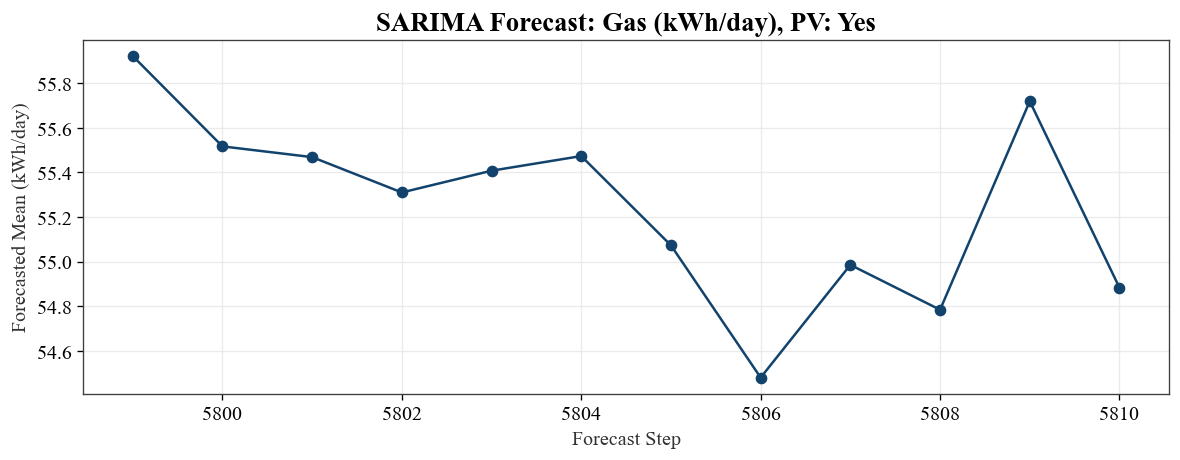

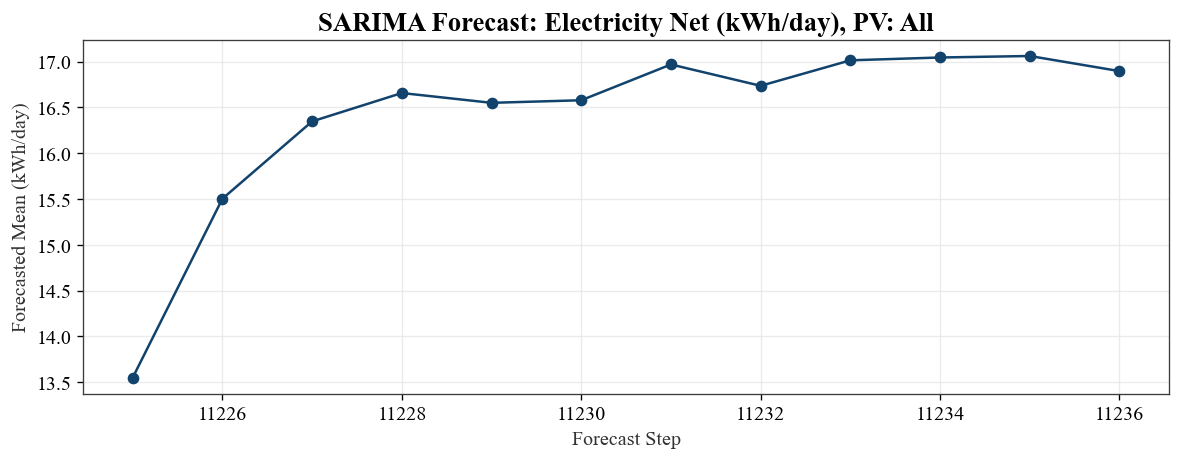

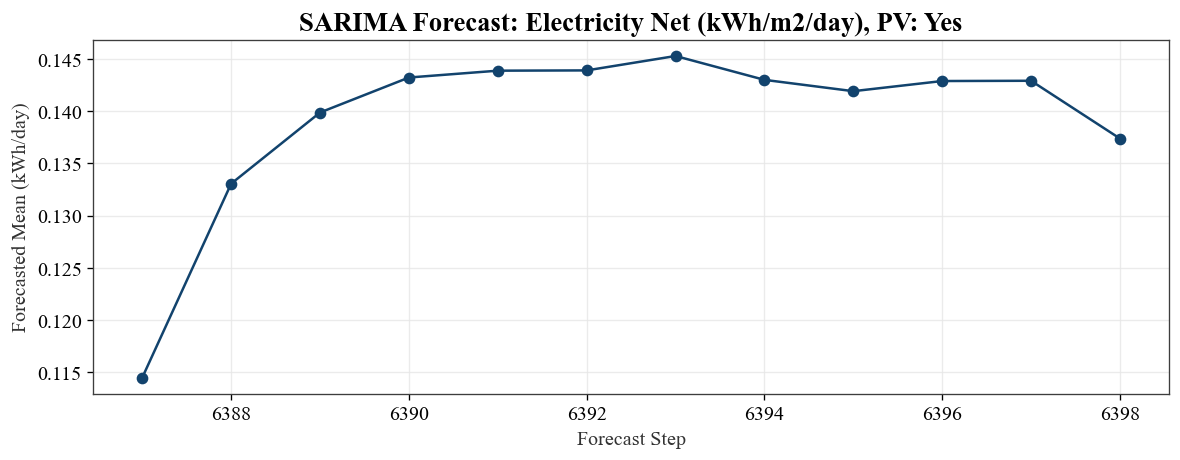

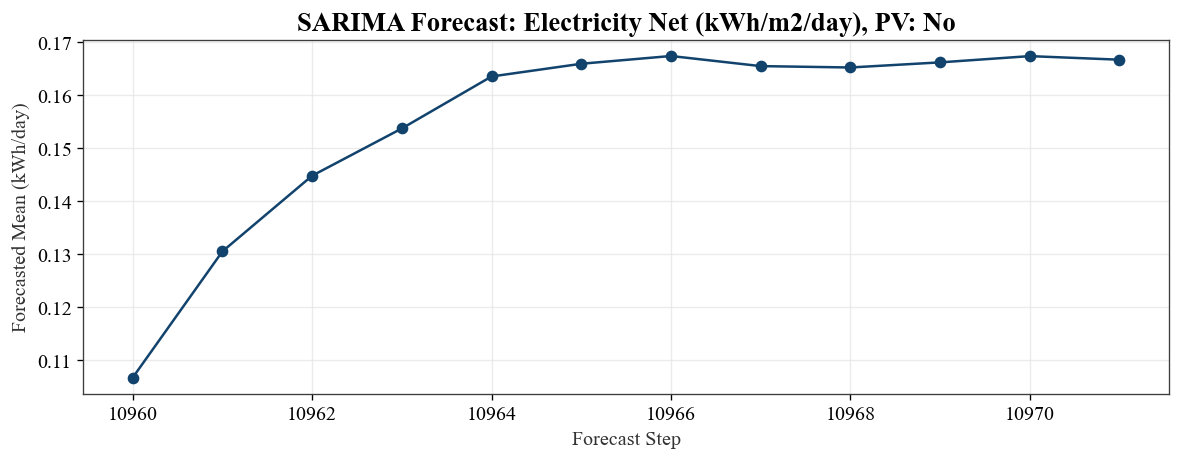

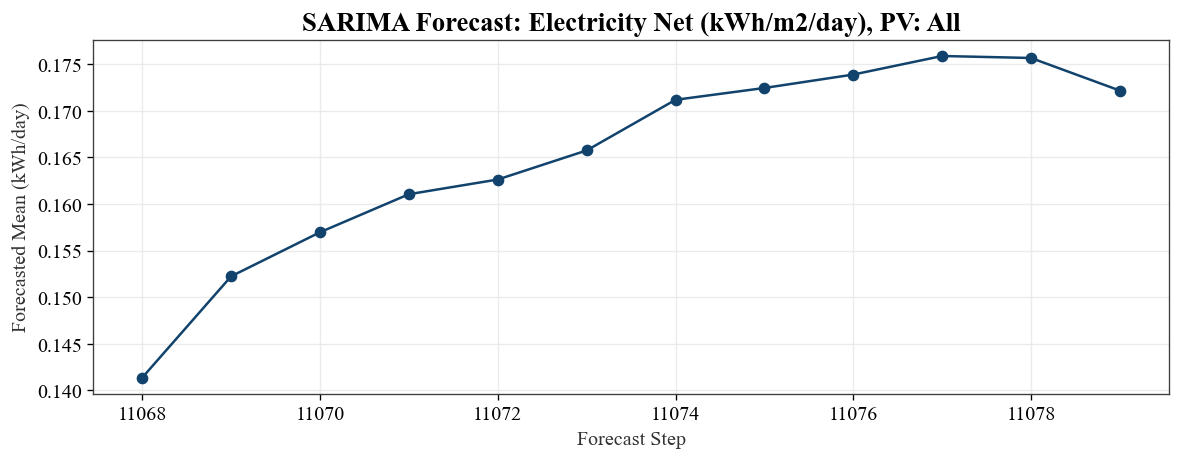

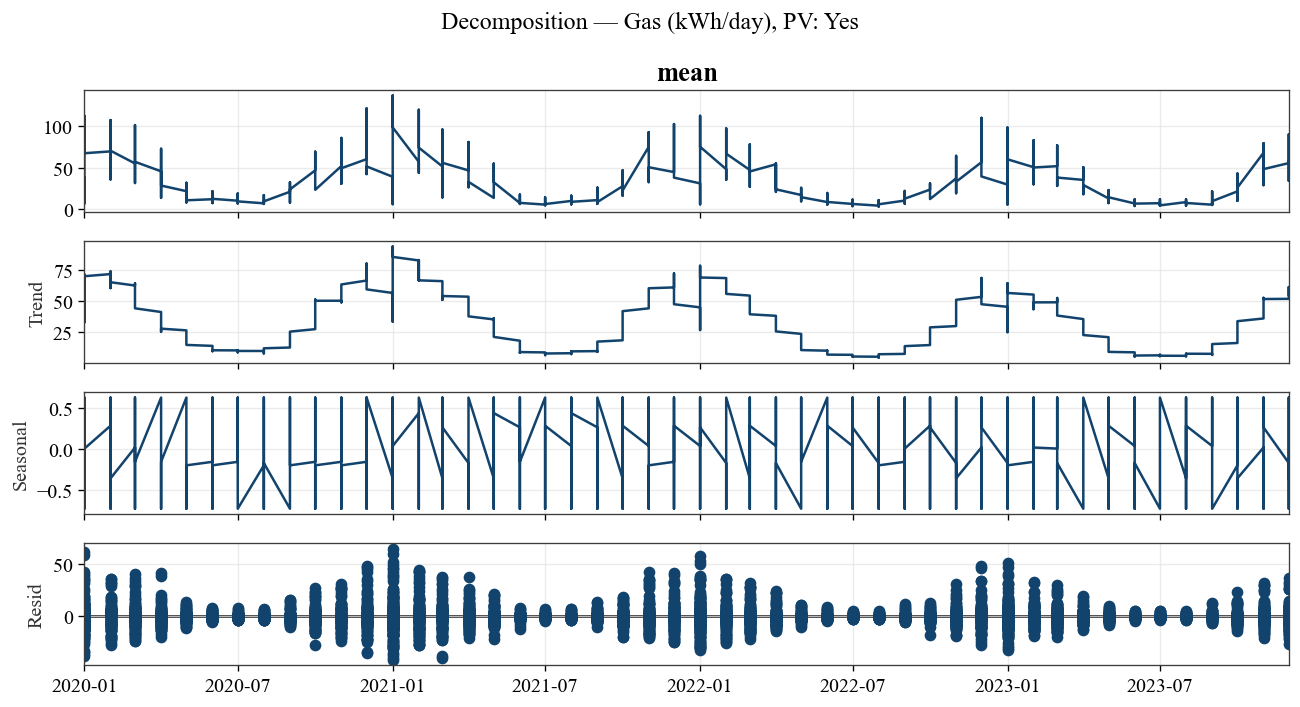

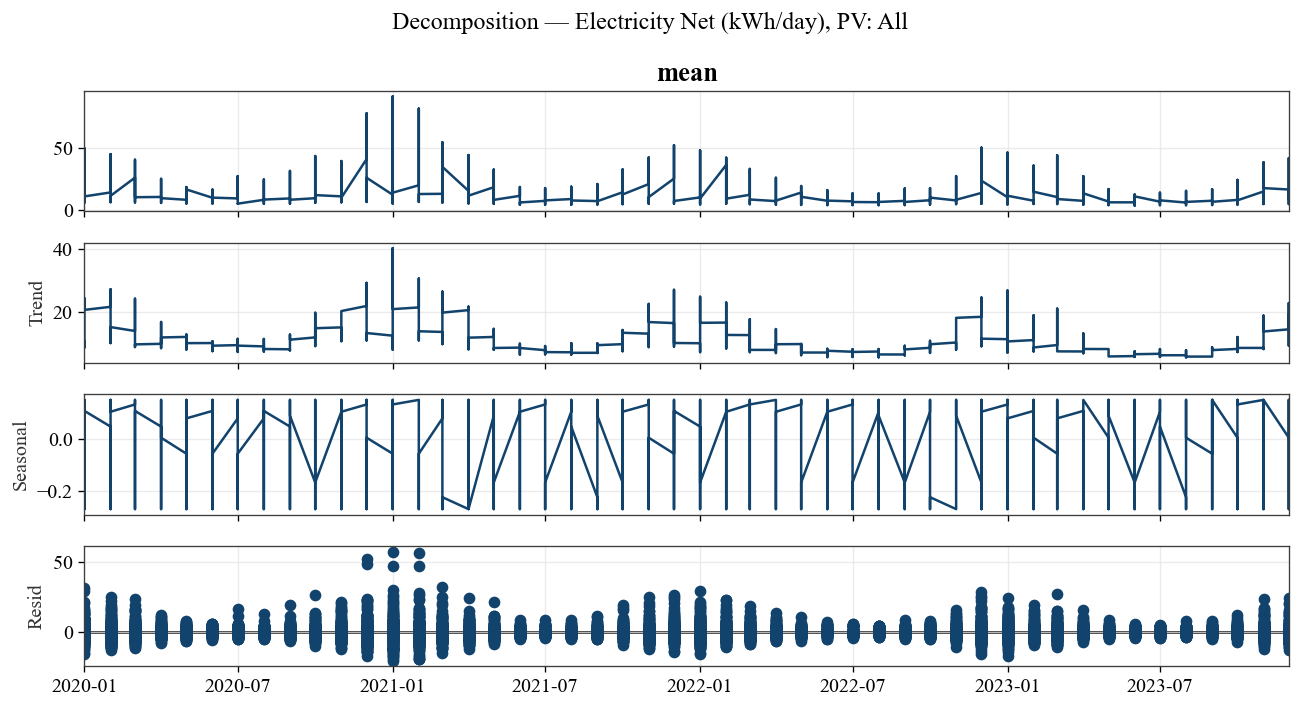

Top 5 by SeasonalityStrength:
                                  Subgroup  SeasonalityStrength  \
39  Electricity exports_kWh/person/day_No             1.000000   
9          Electricity exports_kWh/day_No             1.000000   
12      Electricity exports_kWh/m2/day_No             1.000000   
8             Electricity net_kWh/day_Yes             0.003868   
4          Electricity net_kWh/m2/day_All             0.003792   

    SeasonalAmplitude  SeasonalPeakStep  
39           0.000000                 0  
9            0.000000                 0  
12           0.000000                 0  
8            1.563826                 1  
4            0.008696                 7  

Top 5 by TrendStrength:
                                  Subgroup  TrendStrength
9          Electricity exports_kWh/day_No       1.000000
39  Electricity exports_kWh/person/day_No       1.000000
12      Electricity exports_kWh/m2/day_No       1.000000
13        Electricity exports_kWh/day_Yes       0.937806
18       

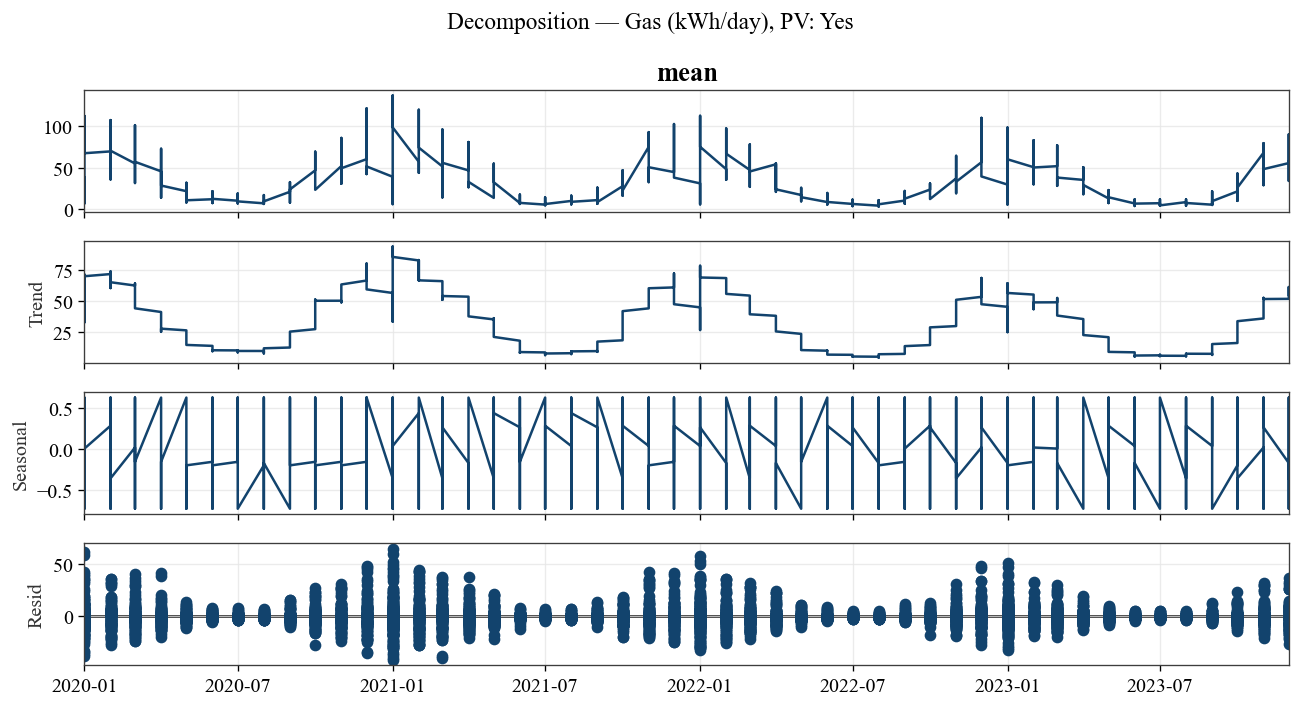

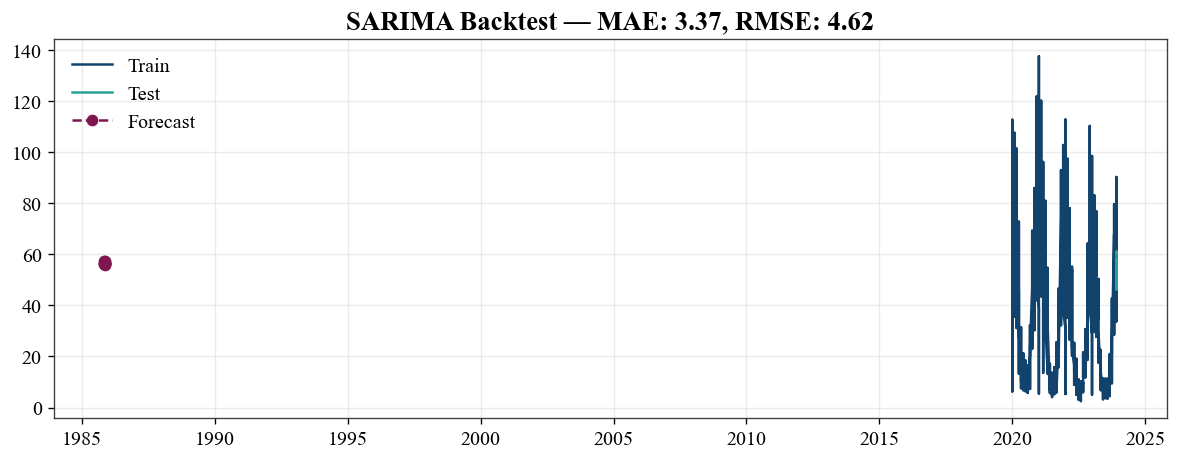

Backtest — Gas_kWh/day_Yes: MAE=3.366, RMSE=4.624


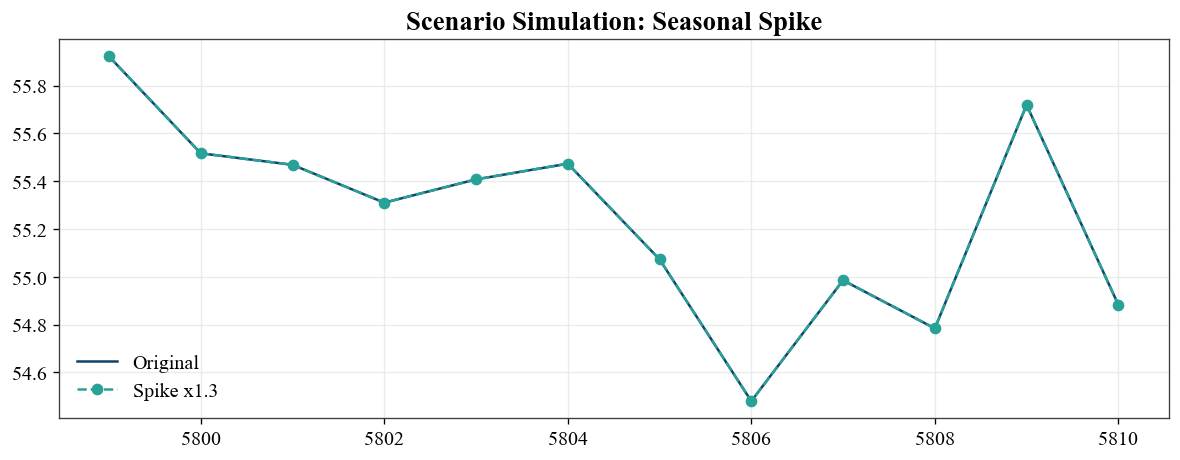


✅ Inline dissertation demo complete.


In [4]:
# Core data handling
import numpy as np
import pandas as pd

# Stats & forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Clustering & scaling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Define theme colors
PRIMARY_COLOR    = "#12436D"  # Dark blue
TURQUOISE_COLOR  = "#28A197"  # Turquoise
DARK_PINK_COLOR  = "#801650"  # Dark pink
ORANGE_COLOR     = "#F46A25"  # Orange
DARK_GREY        = "#3D3D3D"  # Dark grey
LIGHT_PURPLE     = "#A285D1"  # Light purple
LIGHT_BG         = "#F5F5F5"  # Light gray background
DARK_TEXT        = "#333333"  # Dark text

PALETTE = [
    PRIMARY_COLOR, TURQUOISE_COLOR, DARK_PINK_COLOR, ORANGE_COLOR,
    DARK_GREY, LIGHT_PURPLE
]
YEAR_COLORS = {2020: PRIMARY_COLOR, 2021: TURQUOISE_COLOR, 2022: DARK_PINK_COLOR, 2023: ORANGE_COLOR}

def set_theme():
    plt.rcParams.update({
        "figure.figsize": (11, 6),
        "figure.dpi": 120,
        "figure.facecolor": "#ffffff",
        "axes.facecolor": "#ffffff",
        "axes.edgecolor": DARK_GREY,
        "axes.labelcolor": DARK_TEXT,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "grid.color": "#E6E6E6",
        "grid.alpha": 0.8,
        "axes.grid": True,
        "font.size": 12,
        "legend.frameon": False,
        "legend.edgecolor": "#00000000",
    })

# Apply theme
set_theme()

class EnergyForecaster:
    def __init__(self, df):
        """
        Initialize the EnergyForecaster with a DataFrame
        """
        self.df = df.copy()
        self.time_series_data = {}
        self.sarima_forecasts = {}
        self.forecast_df = None
        self.ratios_df = None
        self.kmeans_model = None
        self.scaler = None
        self.cluster_profiles_ = None

    # =====================
    # Core pipeline methods
    # =====================
    def preprocess_data(self):
        """Preprocess the data - filter out missing values and ensure proper datetime index"""
        self.df = self.df[self.df['mean'].notnull()]

        if 'aggregation_period' in self.df.columns:
            # Try several date parsing strategies
            for fmt in ['ISO8601', 'mixed', None]:
                try:
                    if fmt:
                        self.df['aggregation_period'] = pd.to_datetime(self.df['aggregation_period'], format=fmt)
                    else:
                        self.df['aggregation_period'] = pd.to_datetime(self.df['aggregation_period'])
                    break
                except Exception:
                    continue
            self.df.set_index('aggregation_period', inplace=True)
        else:
            # Ensure index is datetime
            if not isinstance(self.df.index, pd.DatetimeIndex):
                for fmt in ['ISO8601', 'mixed', None]:
                    try:
                        if fmt:
                            self.df.index = pd.to_datetime(self.df.index, format=fmt)
                        else:
                            self.df.index = pd.to_datetime(self.df.index)
                        break
                    except Exception:
                        continue
        return self.df

    def extract_subgroups(self, min_observations=24, freq='D'):
        """Extract time series per (quantity, unit, has_PV) with enough observations"""
        df_reset = self.df.reset_index()
        subgroups = df_reset[['quantity', 'unit', 'has_PV']].drop_duplicates()
        self.time_series_data = {}

        for _, row in subgroups.iterrows():
            q, u, pv = row['quantity'], row['unit'], row['has_PV']
            subset = df_reset[(df_reset['quantity'] == q) & (df_reset['unit'] == u) & (df_reset['has_PV'] == pv)]
            ts = subset.set_index('aggregation_period')['mean'].sort_index()
            if ts.shape[0] >= min_observations:
                try:
                    ts = ts.asfreq(freq).fillna(method='ffill')
                except Exception:
                    pass
                name = f"{q}_{u}_{pv}"
                self.time_series_data[name] = ts
        return self.time_series_data

    @staticmethod
    def clean_subgroup_name(name):
        """Convert a technical subgroup name into a human-readable label."""
        try:
            quantity_part, unit, pv = name.rsplit("_", 2)
            quantity_readable = quantity_part.replace("_", " ").replace("+", " + ").title()
            return f"{quantity_readable} ({unit}), PV: {str(pv).title()}"
        except Exception:
            return name

    def generate_sarima_forecasts(self, steps=12, order=(1,1,1), seasonal_order=(1,1,1,12)):
        """Generate SARIMA forecasts for all time series"""
        self.sarima_forecasts = {}
        for name, ts in self.time_series_data.items():
            try:
                model = SARIMAX(ts, order=order, seasonal_order=seasonal_order,
                                enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit(disp=False)
                fc = res.get_forecast(steps=steps).predicted_mean
                self.sarima_forecasts[name] = fc
            except Exception:
                # Fallback: repeating last 12 values pattern
                last_n = ts.iloc[-12:] if len(ts) >= 12 else ts
                vals = last_n.values
                while len(vals) < steps:
                    vals = np.concatenate([vals, last_n.values])
                vals = vals[:steps]
                last_date = ts.index[-1]
                freq = getattr(last_date, 'freqstr', None) or 'M'
                idx = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq=freq)
                self.sarima_forecasts[name] = pd.Series(vals, index=idx)

        valid = {k: v for k, v in self.sarima_forecasts.items() if v is not None and not isinstance(v, str)}
        self.forecast_df = pd.DataFrame(valid) if valid else pd.DataFrame()
        return self.forecast_df

    def calculate_peak_trough_ratios(self):
        """Calculate peak-to-trough ratios for all forecasts"""
        if self.forecast_df.empty:
            return pd.DataFrame()
        def safe_ratio(x):
            mn = x.min()
            return np.nan if mn == 0 else x.max() / mn
        ratios = self.forecast_df.apply(safe_ratio, axis=0)
        self.ratios_df = ratios.reset_index()
        self.ratios_df.columns = ['Subgroup', 'Peak:Trough Ratio']
        return self.ratios_df

    def cluster_forecasts(self, n_clusters=4, random_state=42):
        """KMeans cluster the forecast shapes (drops columns with NaNs)."""
        if self.forecast_df is None or self.forecast_df.empty:
            return None, None
        clean = self.forecast_df.dropna(axis=1)
        if clean.empty:
            return None, None
        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(clean.T)
        self.kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = self.kmeans_model.fit_predict(X)
        mapping = dict(zip(clean.columns, labels))
        all_clusters = [mapping.get(col, np.nan) for col in self.forecast_df.columns]

        if self.ratios_df is None or self.ratios_df.empty:
            self.calculate_peak_trough_ratios()
        self.ratios_df['Cluster'] = all_clusters

        df_with_clusters = self.forecast_df.copy()
        df_with_clusters['Cluster'] = all_clusters
        return df_with_clusters, labels

    def name_clusters_based_on_behavior(self, forecast_df_with_clusters):
        """Assign human-readable names to clusters based on seasonal behavior"""
        if forecast_df_with_clusters is None or forecast_df_with_clusters.empty:
            return {}
        self.cluster_profiles_ = forecast_df_with_clusters.groupby('Cluster').mean(numeric_only=True)

        def classify(avg_series):
            if len(avg_series) == 0:
                return 'Unknown Pattern'
            vals = avg_series.values
            peak_month = int(np.nanargmax(vals))
            peak_val = np.nanmax(vals)
            min_val = np.nanmin(vals)
            if min_val == 0:
                return 'Zero Values Present'
            pt = peak_val / min_val
            if pt < 1.2:
                return 'Flat Consumption'
            if peak_month in [11, 0, 1]:  # Winter (Dec, Jan, Feb)
                return 'Winter Peaker'
            if peak_month in [5, 6, 7]:   # Summer (Jun, Jul, Aug)
                return 'Summer Peaker'
            if peak_month in [2, 3, 4]:   # Spring (Mar, Apr, May)
                return 'Spring Peaker'
            if peak_month in [8, 9, 10]:  # Autumn (Sep, Oct, Nov)
                return 'Autumn Peaker'
            return 'Highly Variable'

        name_map = {label: classify(row) for label, row in self.cluster_profiles_.iterrows()}
        self.ratios_df['Cluster Name'] = self.ratios_df['Cluster'].map(name_map)
        return name_map

    # =====================
    # Inline visualization helpers
    # =====================
    def plot_forecasts(self, subgroup_names=None, n_examples=5):
        if self.forecast_df is None or self.forecast_df.empty:
            return
        cols = list(self.forecast_df.columns)
        if 'Cluster' in cols:
            cols.remove('Cluster')
        if subgroup_names is None:
            subgroup_names = cols[:min(n_examples, len(cols))]
        for name in subgroup_names:
            if name in cols:
                title = self.clean_subgroup_name(name)
                plt.figure(figsize=(10, 4))
                plt.plot(self.forecast_df[name], marker='o')
                plt.title(f"SARIMA Forecast: {title}")
                plt.xlabel("Forecast Step")
                plt.ylabel("Forecasted Mean (kWh/day)")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

    def visualize_cluster_differences(self):
        if self.ratios_df is None or self.ratios_df.empty or 'Cluster Name' not in self.ratios_df:
            return
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster Name', y='Peak:Trough Ratio', data=self.ratios_df)
        plt.title("Seasonal Intensity by Cluster Type")
        plt.xlabel("Cluster Type")
        plt.ylabel("Peak:Trough Ratio")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # =====================
    # 🔷 OOP utilities with inline results
    # =====================
    def decompose_time_series(self, ts, model_type='additive', period=12, title="Time Series Decomposition"):
        """Plot seasonal decomposition inline."""
        result = seasonal_decompose(ts, model=model_type, period=period)
        result.plot()
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
        return result

    def backtest_sarima(self, ts, order=(1,1,1), seasonal_order=(1,1,1,12), test_size=12):
        """Train/test split backtest, print metrics, and plot inline."""
        train, test = ts[:-test_size], ts[-test_size:]
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        fc = res.get_forecast(steps=test_size).predicted_mean
        mae = mean_absolute_error(test, fc)
        rmse = np.sqrt(mean_squared_error(test, fc))

        # Inline plot
        plt.figure(figsize=(10,4))
        plt.plot(train.index, train.values, label='Train')
        plt.plot(test.index, test.values, label='Test')
        plt.plot(fc.index, fc.values, label='Forecast', linestyle='--', marker='o')
        plt.title(f"SARIMA Backtest — MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        return mae, rmse, test, fc

    def detect_cluster_outliers(self):
        """Compute distance-to-centroid for clustered forecasts; return sorted DataFrame and plot top outliers."""
        if self.kmeans_model is None or self.forecast_df is None or self.forecast_df.empty:
            return None
        clean = self.forecast_df.drop(columns=['Cluster'], errors='ignore').dropna(axis=1)
        X = self.scaler.transform(clean.T)
        dists = pairwise_distances(X, self.kmeans_model.cluster_centers_[self.kmeans_model.labels_])
        # Map back to columns present in clean
        out = pd.DataFrame({'Subgroup': clean.columns, 'Distance': dists.ravel()})
        out = out.sort_values('Distance', ascending=False)

        # Inline bar of top 10
        top = out.head(10)
        plt.figure(figsize=(10,4))
        plt.bar(top['Subgroup'].astype(str), top['Distance'])
        plt.title('Top Cluster Outliers (distance to centroid)')
        plt.ylabel('Distance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        return out

    def integrate_exogenous(self, ts, exog_df):
        """Align a series with an exogenous regressor DataFrame (same index)."""
        exog = exog_df.loc[ts.index]
        return ts, exog

    def summarize_clusters(self):
        """Return per-cluster summary stats and plot cluster archetypes inline."""
        if self.ratios_df is None or self.ratios_df.empty or self.cluster_profiles_ is None:
            return None
        # Summary table
        summary = self.ratios_df.groupby('Cluster Name')['Peak:Trough Ratio'].agg(['mean','max','min','std']).reset_index()

        # Plot archetypes
        for label, row in self.cluster_profiles_.iterrows():
            plt.figure(figsize=(8,3))
            plt.plot(row.values, marker='o')
            name = f"Cluster {label}"
            if 'Cluster Name' in self.ratios_df.columns:
                nm = self.ratios_df.loc[self.ratios_df['Cluster']==label, 'Cluster Name'].dropna()
                if not nm.empty:
                    name = f"{name} — {nm.iloc[0]}"
            plt.title(name)
            plt.xlabel('Forecast Step')
            plt.ylabel('Avg kWh/day')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        return summary

    def simulate_energy_spike(self, forecast_series, multiplier=1.2, spike_steps=(0,1,11)):
        """Clone a forecast series and apply spikes on selected steps, then plot inline."""
        sim = forecast_series.copy()
        for s in spike_steps:
            if 0 <= s < len(sim):
                sim.iloc[s] = sim.iloc[s] * multiplier
        # Plot
        plt.figure(figsize=(10,4))
        plt.plot(forecast_series.index, forecast_series.values, label='Original')
        plt.plot(sim.index, sim.values, label=f'Spike x{multiplier}', linestyle='--', marker='o')
        plt.title('Scenario Simulation: Seasonal Spike')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        return sim

    # =====================
    # 🔶 NEW: Decompose ALL subgroups and compute metrics
    # =====================
    def decompose_all_and_score(self, period=12, model='additive', show_examples=0):
        """
        For every time series in `self.time_series_data`, run seasonal_decompose and
        compute decomposition metrics, returned as a DataFrame (inline only, no saving).

        Metrics per subgroup:
        - TrendStrength (Hyndman):  max(0, 1 - Var(R)/Var(T+R))
        - SeasonalityStrength:       max(0, 1 - Var(R)/Var(S+R))
        - ResidualVariance
        - SeasonalAmplitude:         max(Seasonal) - min(Seasonal)
        - SeasonalPeakStep:          argmax(average seasonal by position within cycle)
        - ReconRMSE:                 RMSE between original and (T + S + R) (sanity)

        Parameters
        ----------
        period : int
            Seasonal period for decomposition (e.g., 12 for monthly, 7 for weekly).
        model : str
            'additive' or 'multiplicative'.
        show_examples : int
            Plot this many example decompositions inline (0 = none).
        """
        rows = []
        plotted = 0
        for name, ts in self.time_series_data.items():
            ts_clean = ts.dropna()
            if len(ts_clean) < max(24, 2*period):
                continue
            try:
                dec = seasonal_decompose(ts_clean, model=model, period=period)
                T = pd.Series(dec.trend, index=ts_clean.index)
                S = pd.Series(dec.seasonal, index=ts_clean.index)
                R = pd.Series(dec.resid, index=ts_clean.index)
                dfc = pd.concat([ts_clean.rename('Y'), T.rename('T'), S.rename('S'), R.rename('R')], axis=1).dropna()
                if dfc.empty:
                    continue
                Y, T, S, R = dfc['Y'], dfc['T'], dfc['S'], dfc['R']

                var = np.nanvar
                trend_strength = max(0.0, 1.0 - var(R) / max(var(T + R), 1e-12))
                seas_strength  = max(0.0, 1.0 - var(R) / max(var(S + R), 1e-12))
                resid_var      = var(R)
                seas_amp       = float(np.nanmax(S) - np.nanmin(S))
                # Robust peak step: average S by cycle position
                pos = (np.arange(len(S)) % period)
                s_by_pos = pd.Series(S.values).groupby(pos).mean()
                peak_step = int(s_by_pos.values.argmax()) if len(s_by_pos)>0 else np.nan
                recon = T + S + R
                rmse = float(np.sqrt(np.nanmean((Y - recon)**2)))

                rows.append({
                    'Subgroup': name,
                    'TrendStrength': trend_strength,
                    'SeasonalityStrength': seas_strength,
                    'ResidualVariance': resid_var,
                    'SeasonalAmplitude': seas_amp,
                    'SeasonalPeakStep': peak_step,
                    'ReconRMSE': rmse
                })

                if plotted < show_examples:
                    dec.plot()
                    plt.suptitle(f"Decomposition — {self.clean_subgroup_name(name)}")
                    plt.tight_layout()
                    plt.show()
                    plotted += 1
            except Exception:
                continue

        metrics_df = pd.DataFrame(rows)
        if not metrics_df.empty:
            top_seas = metrics_df.sort_values('SeasonalityStrength', ascending=False).head(5)
            top_trend = metrics_df.sort_values('TrendStrength', ascending=False).head(5)
            print("Top 5 by SeasonalityStrength:\n", top_seas[['Subgroup','SeasonalityStrength','SeasonalAmplitude','SeasonalPeakStep']])
            print("\nTop 5 by TrendStrength:\n", top_trend[['Subgroup','TrendStrength']])
        return metrics_df

    def merge_with_metadata(self, metadata_df, on='Subgroup'):
        """Merge ratios/clusters with household or equity metadata."""
        if self.ratios_df is None or self.ratios_df.empty:
            return None
        return pd.merge(self.ratios_df, metadata_df, how='left', on=on)

    # =====================
    # Orchestrator for the extended demo
    # =====================
    def run_extended_demo(self, subgroup_key=None, temp_df=None):
        """
        Optional helper to show inline outputs end-to-end for one subgroup:
        - Decompose
        - Backtest SARIMA
        - Outlier detection
        - Cluster summaries & archetypes
        - Scenario simulation
        """
        # Ensure base pipeline ran
        if self.forecast_df is None or self.forecast_df.empty:
            raise RuntimeError("Run the core pipeline first (preprocess -> extract_subgroups -> generate_sarima_forecasts -> calculate_peak_trough_ratios -> cluster_forecasts -> name_clusters_based_on_behavior).")

        # Choose a subgroup
        cols = [c for c in self.forecast_df.columns if c != 'Cluster']
        if not cols:
            raise RuntimeError("No forecast columns available.")
        key = subgroup_key or cols[0]

        # 1) Decomposition (use the original historical ts if available)
        ts_hist = self.time_series_data.get(key)
        if ts_hist is not None and len(ts_hist) >= 24:
            self.decompose_time_series(ts_hist, model_type='additive', period=12,
                                       title=f"Decomposition — {self.clean_subgroup_name(key)}")

        # 2) Backtest SARIMA
        if ts_hist is not None and len(ts_hist) >= 24:
            mae, rmse, _, _ = self.backtest_sarima(ts_hist)
            print(f"Backtest — {key}: MAE={mae:.3f}, RMSE={rmse:.3f}")

        # 3) Outliers
        outliers = self.detect_cluster_outliers()
        if outliers is not None:
            display_cols = outliers.head(10)
            print("Top cluster outliers:\n", display_cols)

        # 4) Cluster summaries & archetypes
        summary = self.summarize_clusters()
        if summary is not None:
            print("\nCluster summary (Peak:Trough Ratio stats):\n", summary)

        # 5) Scenario simulation on chosen subgroup forecast
        if key in self.forecast_df.columns:
            self.simulate_energy_spike(self.forecast_df[key], multiplier=1.3, spike_steps=(0,1,11))

        # 6) Optional exogenous alignment example
        if temp_df is not None and ts_hist is not None:
            ts_aligned, exog = self.integrate_exogenous(ts_hist, temp_df)
            print("Exogenous aligned head:\n", exog.head())

        print("\nExtended demo complete.")


# =====================
# 📘 Dissertation‑Style Example Usage (Inline Only)
# =====================
# This block shows a clean, reproducible flow that produces inline figures
# and printed summaries for a Results chapter, without saving files.

# --- 1) Build forecaster and run core pipeline ---
ef = EnergyForecaster(df)
ef.preprocess_data()
ef.extract_subgroups(min_observations=24, freq='D')
ef.generate_sarima_forecasts(steps=12)
ef.calculate_peak_trough_ratios()
fc_with_clusters, _ = ef.cluster_forecasts(n_clusters=4)
ef.name_clusters_based_on_behavior(fc_with_clusters)

# --- 2) Forecast curves for a few subgroups ---
ef.plot_forecasts(n_examples=5)

# --- 3) Cluster differences ---
ef.visualize_cluster_differences()

# --- 4) Outlier detection ---
outliers_df = ef.detect_cluster_outliers()
if outliers_df is not None:
    print("Top‑10 outliers (distance to centroid):\n", outliers_df.head(10))

# --- 5) Cluster summaries & archetypes ---
summary = ef.summarize_clusters()
if summary is not None:
    print("\nCluster summary (Peak:Trough Ratio stats):\n", summary)

# --- 6) NEW: Decompose ALL subgroups and compute metrics (inline table) ---
# Choose a period that matches your data frequency/season (e.g., 12 for monthly, 7 for weekly)
metrics_df = ef.decompose_all_and_score(period=12, model='additive', show_examples=2)
print("\nDecomposition metrics (head):\n", metrics_df.head())

# --- 7) Decomposition + Backtest on focal subgroup ---
focal = next(iter(ef.time_series_data.keys()), None)
if focal is not None:
    ts_hist = ef.time_series_data[focal]
    ef.decompose_time_series(ts_hist, model_type='additive', period=12,
                             title=f"Decomposition — {EnergyForecaster.clean_subgroup_name(focal)}")
    mae, rmse, _, _ = ef.backtest_sarima(ts_hist)
    print(f"Backtest — {focal}: MAE={mae:.3f}, RMSE={rmse:.3f}")

# --- 8) Scenario simulation ---
if focal is not None and focal in ef.forecast_df.columns:
    ef.simulate_energy_spike(ef.forecast_df[focal], multiplier=1.3, spike_steps=(0,1,11))

print("\n✅ Inline dissertation demo complete.")

In [5]:
valid_cols = [c for c in ef.forecast_df.columns if c != "Cluster" 
              and not ef.forecast_df[c].isna().all()]

print("Valid forecast subgroups with data:\n", valid_cols)


Valid forecast subgroups with data:
 ['Gas_kWh/day_Yes', 'Electricity net_kWh/day_All', 'Electricity net_kWh/m2/day_Yes', 'Electricity net_kWh/m2/day_No', 'Electricity net_kWh/m2/day_All', 'Electricity net_kWh/day_No', 'Electricity imports_kWh/person/day_No', 'Electricity imports_kWh/person/day_All', 'Electricity net_kWh/day_Yes', 'Electricity exports_kWh/day_No', 'Electricity exports_kWh/day_All', 'Electricity exports_kWh/m2/day_Yes', 'Electricity exports_kWh/m2/day_No', 'Electricity exports_kWh/day_Yes', 'Electricity net_kWh/person/day_Yes', 'Electricity net_kWh/person/day_No', 'Electricity net_kWh/person/day_All', 'Electricity imports_kWh/person/day_Yes', 'Gas_kWh/m2/day_No', 'Gas_kWh/m2/day_All', 'Gas_kWh/person/day_Yes', 'Gas_kWh/person/day_No', 'Gas_kWh/m2/day_Yes', 'Gas_kWh/day_No', 'Gas_kWh/day_All', 'Gas_kWh/person/day_All', 'Electricity imports_kWh/m2/day_Yes', 'Electricity imports_kWh/m2/day_No', 'Electricity imports_kWh/m2/day_All', 'Electricity imports_kWh/day_All', 'Elect

In [6]:
non_empty = []
for col in valid_cols:
    series = ef.forecast_df[col]
    if series.notna().sum() > 0:
        non_empty.append((col, series.notna().sum(), series.min(), series.max()))

# Show a preview
for name, count, mn, mx in non_empty[:10]:
    print(f"{name:45s} | non-NaN points: {count:4d} | min={mn:.3f} | max={mx:.3f}")


Gas_kWh/day_Yes                               | non-NaN points:   12 | min=54.480 | max=55.922
Electricity net_kWh/day_All                   | non-NaN points:   12 | min=13.550 | max=17.062
Electricity net_kWh/m2/day_Yes                | non-NaN points:   12 | min=0.115 | max=0.145
Electricity net_kWh/m2/day_No                 | non-NaN points:   12 | min=0.107 | max=0.167
Electricity net_kWh/m2/day_All                | non-NaN points:   12 | min=0.141 | max=0.176
Electricity net_kWh/day_No                    | non-NaN points:   12 | min=16.657 | max=18.096
Electricity imports_kWh/person/day_No         | non-NaN points:   12 | min=10.251 | max=12.330
Electricity imports_kWh/person/day_All        | non-NaN points:   12 | min=9.808 | max=12.420
Electricity net_kWh/day_Yes                   | non-NaN points:   12 | min=12.806 | max=18.369
Electricity exports_kWh/day_No                | non-NaN points:   12 | min=0.000 | max=0.000


In [7]:
focal = "Electricity net_kWh/day_Yes"  # has 12 points, 12.8–18.4 kWh/day
base = ef.forecast_df[focal].dropna()
print(base)


6638    12.806092
6639    15.704596
6640    16.779005
6641    16.922236
6642    17.533250
6643    18.369119
6644    17.766817
6645    16.847538
6646    17.059729
6647    17.268679
6648    17.619050
6649    17.518796
Name: Electricity net_kWh/day_Yes, dtype: float64


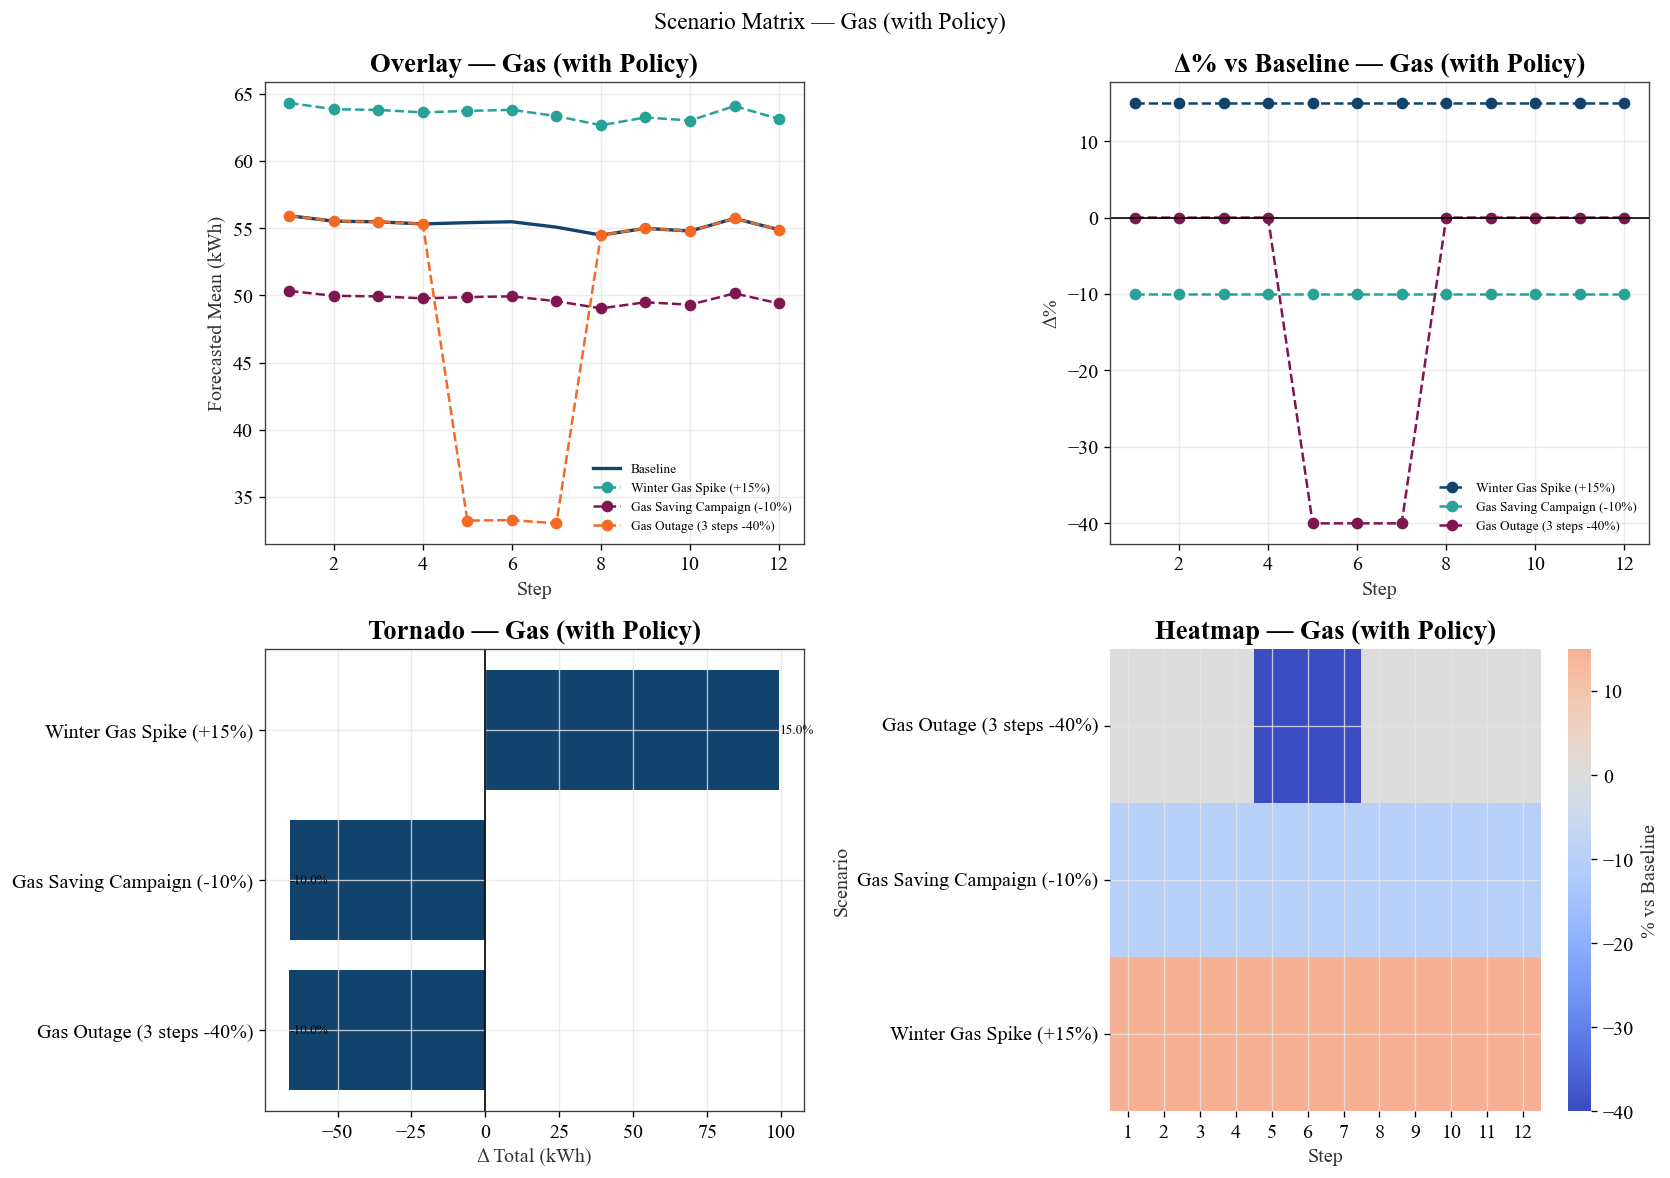

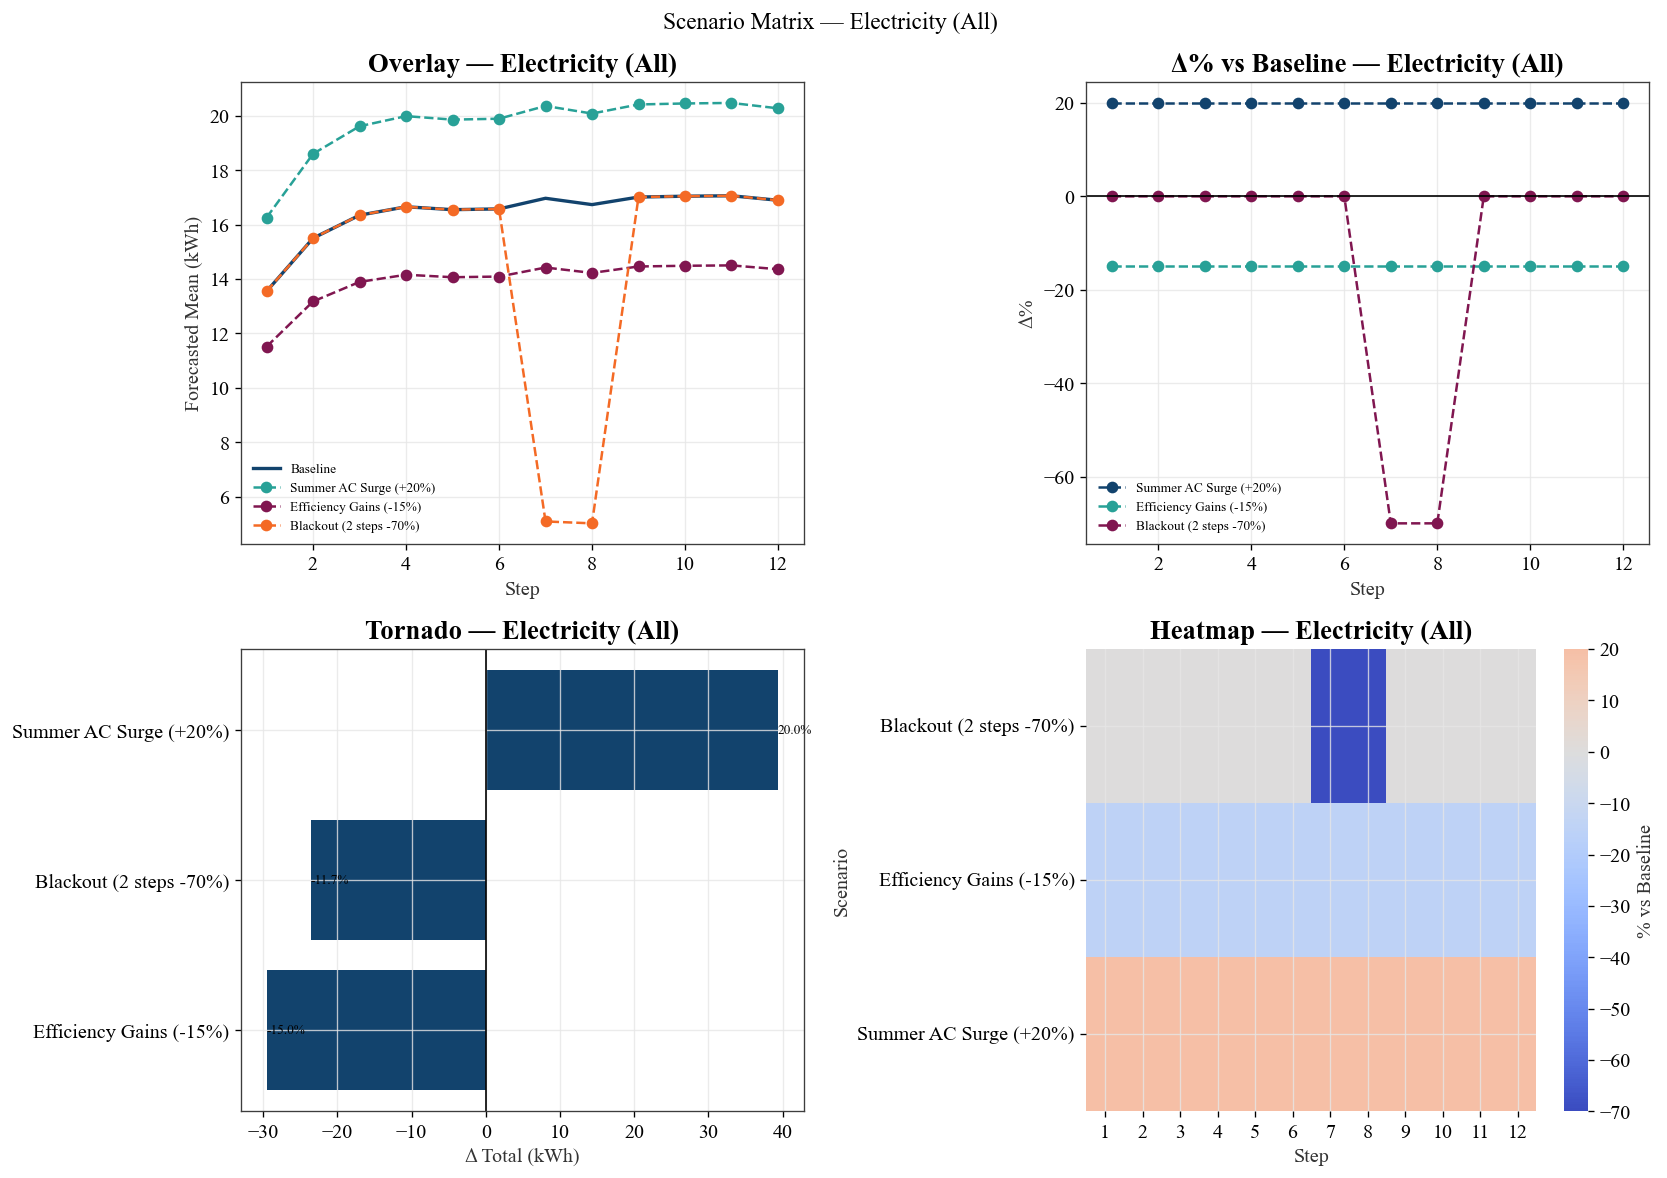

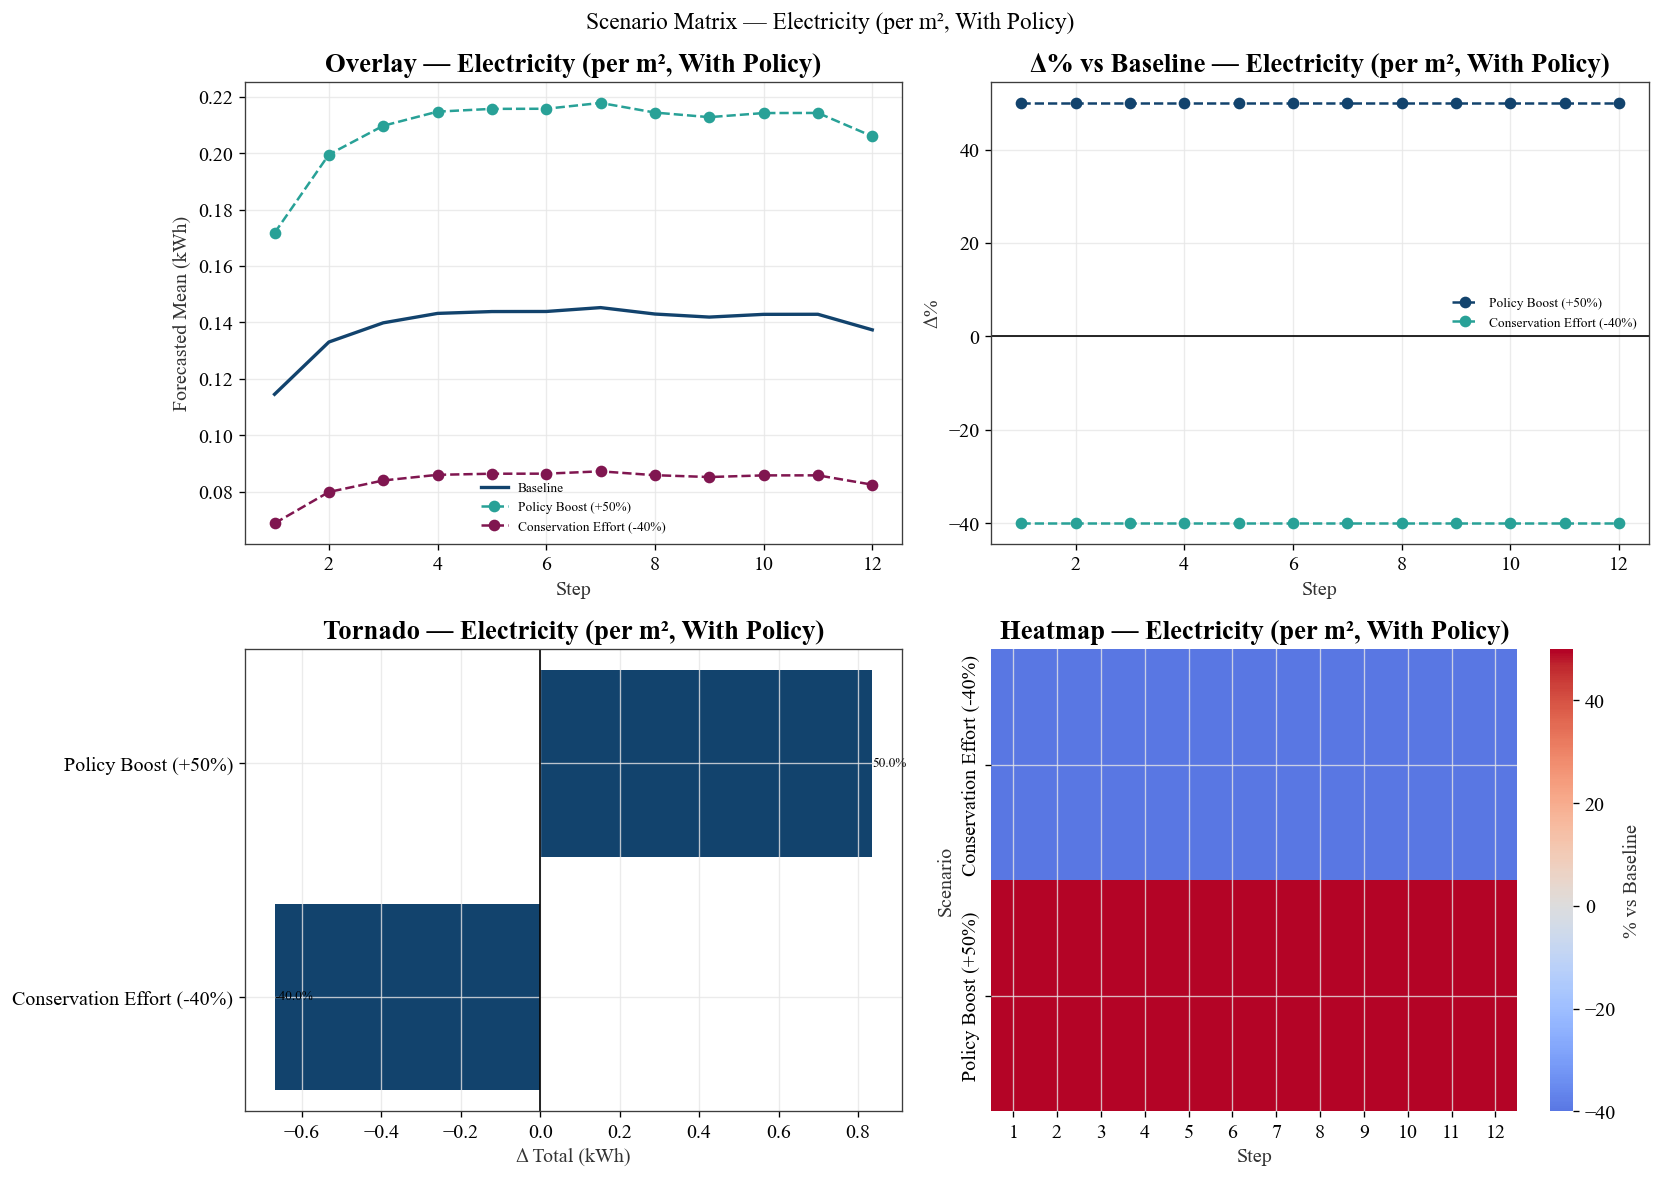

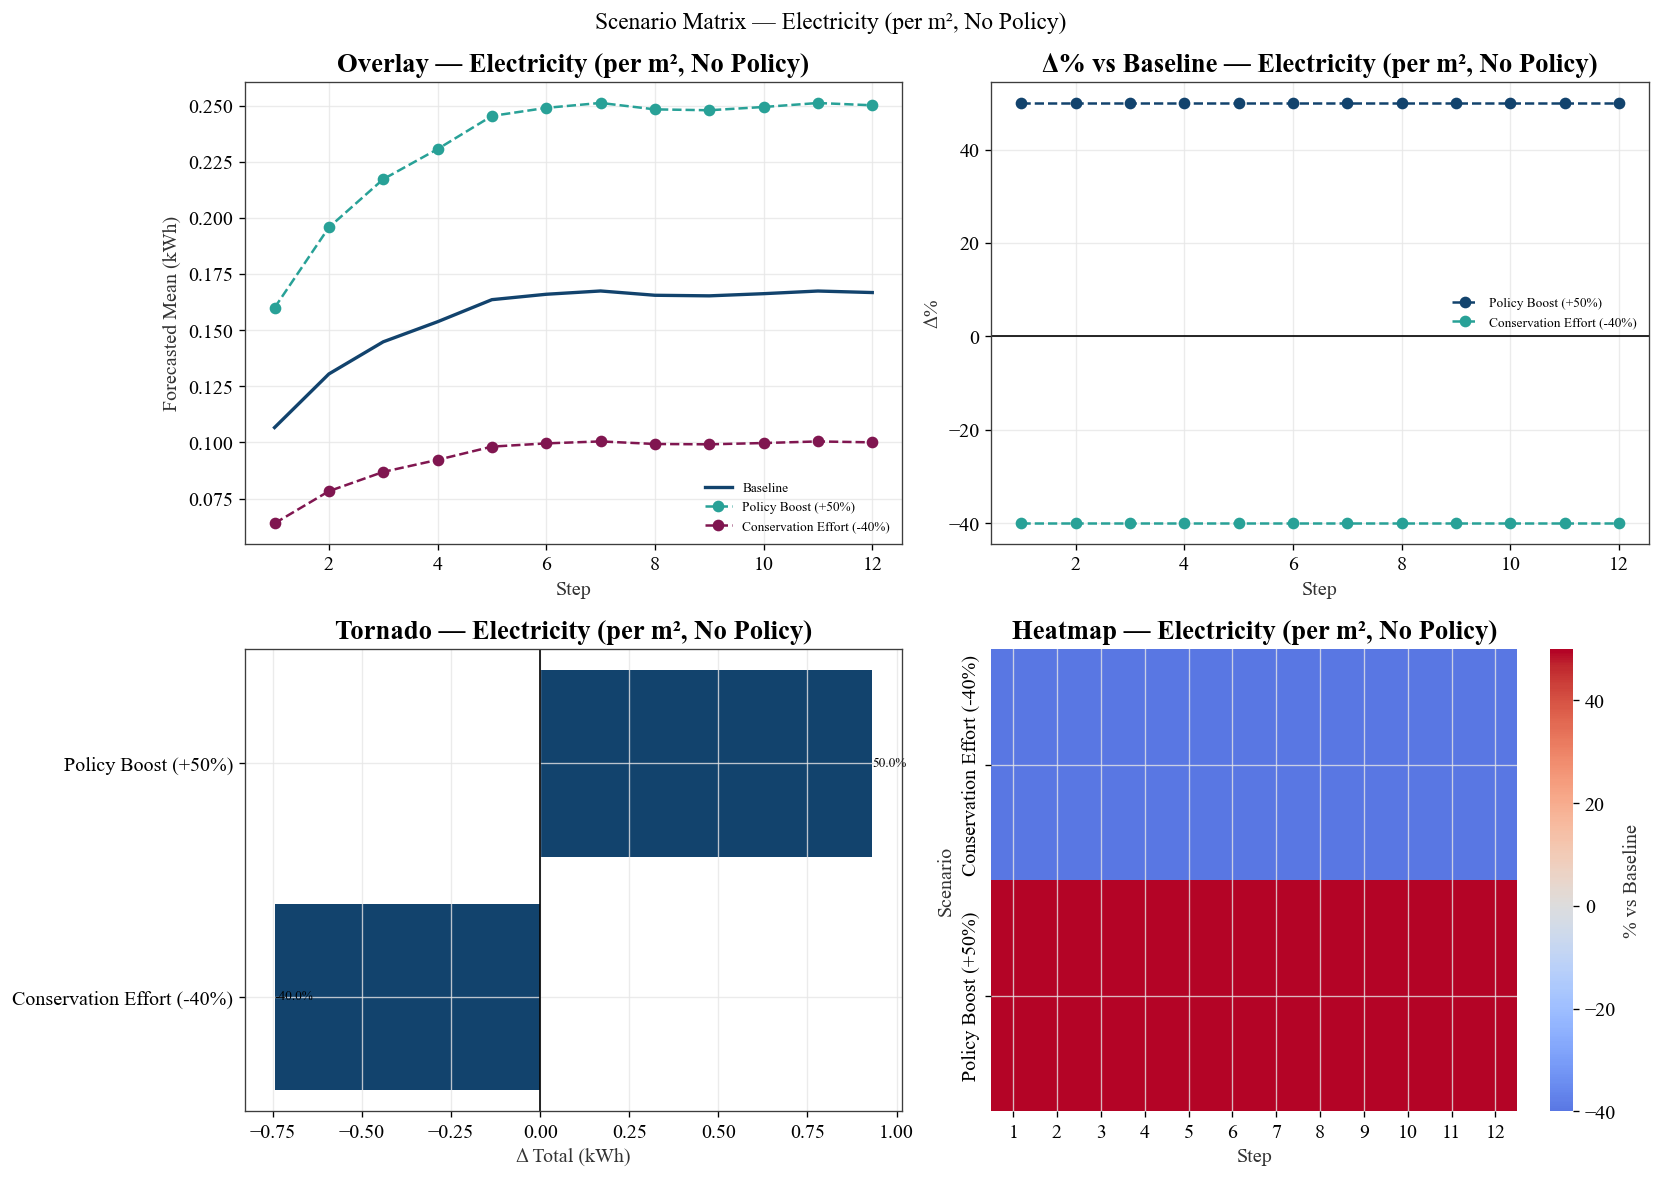

In [8]:
# =====================
# Custom Scenarios + 4-plot matrix per subgroup (fixed)
# =====================

# Apply theme
set_theme()

def apply_window_multiplier(series, start, length, mult):
    """
    Apply a multiplier on a specified window of steps in the series.
    Only multiplies the values for indices from 'start' to 'start + length - 1'.
    Returns a new series with the modified values.
    """
    result = series.copy()
    indices = result.index[start:start+length]
    result.loc[indices] = result.loc[indices] * mult
    return result

def summarize_series_delta(baseline, scenario):
    """
    Calculate summary differences between baseline and scenario series.
    Returns:
        d_abs: total absolute difference (sum)
        d_pct: overall percentage difference (based on mean percentage change)
        d_peak: maximum single-step difference
    """
    delta = scenario - baseline
    d_abs = delta.sum()
    baseline_nonzero = baseline.replace(0, np.nan)
    d_pct = (delta / baseline_nonzero).mean() * 100
    d_peak = delta.max()
    return d_abs, d_pct, d_peak

# =====================
# Custom Scenarios + 4-plot matrix per subgroup (fixed)
# =====================

def build_custom_scenarios(base, label):
    """Return dict of customised scenarios based on subgroup type."""
    scenarios = {}
    if "Gas" in label:
        scenarios["Winter Gas Spike (+15%)"] = base * 1.15
        scenarios["Gas Saving Campaign (-10%)"] = base * 0.90
        scenarios["Gas Outage (3 steps -40%)"] = apply_window_multiplier(base, start=4, length=3, mult=0.60)
    elif "net_kWh/day" in label:
        scenarios["Summer AC Surge (+20%)"] = base * 1.20
        scenarios["Efficiency Gains (-15%)"] = base * 0.85
        scenarios["Blackout (2 steps -70%)"] = apply_window_multiplier(base, start=6, length=2, mult=0.30)
    elif "m2/day" in label:
        scenarios["Policy Boost (+50%)"] = base * 1.50
        scenarios["Conservation Effort (-40%)"] = base * 0.60
    else:
        scenarios["Generic Spike (+10%)"] = base * 1.10
        scenarios["Generic Dip (-10%)"] = base * 0.90
    return scenarios

def plot_matrix_for_subgroup(base, scenarios, label):
    """4-panel visualization matrix for one subgroup."""
    steps = np.arange(1, len(base)+1)   # normalized step axis
    
    plt.figure(figsize=(14,10))

    # (1) Overlay
    plt.subplot(2,2,1)
    plt.plot(steps, base.values, label="Baseline", linewidth=2)
    for name, s in scenarios.items():
        plt.plot(steps, s.values, linestyle='--', marker='o', label=name)
    plt.title(f"Overlay — {label}")
    plt.xlabel("Step"); plt.ylabel("Forecasted Mean (kWh)"); plt.grid(True); plt.legend(fontsize=8)

    # (2) Delta line plot (% vs baseline)
    plt.subplot(2,2,2)
    for name, s in scenarios.items():
        d_pct = ((s - base) / base.replace(0, np.nan)) * 100.0
        plt.plot(steps, d_pct.values, marker='o', linestyle='--', label=name)
    plt.axhline(0, linewidth=1, color="black")
    plt.title(f"Δ% vs Baseline — {label}")
    plt.xlabel("Step"); plt.ylabel("Δ%"); plt.grid(True); plt.legend(fontsize=8)

    # (3) Tornado (absolute + % change)
    plt.subplot(2,2,3)
    summary_rows = []
    for name, s in scenarios.items():
        d_abs, d_pct, d_peak = summarize_series_delta(base, s)
        summary_rows.append({"Scenario": name, "Δ Total (kWh)": d_abs, "Δ %": d_pct})
    impact_df = pd.DataFrame(summary_rows).sort_values("Δ Total (kWh)")
    bars = plt.barh(impact_df["Scenario"], impact_df["Δ Total (kWh)"])
    for bar, pct in zip(bars, impact_df["Δ %"]):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f"{pct:.1f}%", va="center", ha="left", fontsize=8)
    plt.axvline(0, linewidth=1, color="black")
    plt.title(f"Tornado — {label}")
    plt.xlabel("Δ Total (kWh)")

    # (4) Heatmap (% vs baseline over time)
    plt.subplot(2,2,4)
    heatmap_df = []
    for name, s in scenarios.items():
        rel = ((s - base) / base.replace(0, np.nan)) * 100.0
        heatmap_df.append(pd.DataFrame({"Scenario": name, "Step": steps, "Δ%": rel.values}))
    heatmap_df = pd.concat(heatmap_df, ignore_index=True)
    pivot = heatmap_df.pivot(index="Scenario", columns="Step", values="Δ%")
    sns.heatmap(pivot, annot=False, cmap="coolwarm", center=0, cbar_kws={'label': '% vs Baseline'})
    plt.title(f"Heatmap — {label}")

    plt.suptitle(f"Scenario Matrix — {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

# =====================
# Run for each chosen subgroup (renamed for clarity)
# =====================
chosen_subgroups = {
    "Gas_kWh/day_Yes": "Gas (with Policy)",
    "Electricity net_kWh/day_All": "Electricity (All)",
    "Electricity net_kWh/m2/day_Yes": "Electricity (per m², With Policy)",
    "Electricity net_kWh/m2/day_No": "Electricity (per m², No Policy)"
}

for focal, nice_label in chosen_subgroups.items():
    base = ef.forecast_df[focal].dropna()
    scenarios = build_custom_scenarios(base, focal)
    plot_matrix_for_subgroup(base, scenarios, nice_label)
